In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import BooleanType
from pyspark.sql.types import DoubleType
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
spark = SparkSession.builder.appName('I4').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/23 09:41:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# 02 - Data Understanding

## 2.2 Describing Data

In [2]:
# Load datasets
df_1 = spark.read.csv('Sleep_health_and_lifestyle_dataset.csv', header=True)
df_2 = spark.read.csv('Sleep_health_and_lifestyle_dataset_2.csv', header=True)

# Explore data
# Initial inspection of data
df_1.show()
df_2.show()


+---------+------+---+--------------------+--------------+----------------+-----------------------+------------+-------------+--------------+----------+-----------+--------------+
|Person ID|Gender|Age|          Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level| BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|
+---------+------+---+--------------------+--------------+----------------+-----------------------+------------+-------------+--------------+----------+-----------+--------------+
|        1|  Male| 27|   Software Engineer|           6.1|             3.5|                     42|           6|   Overweight|        126/83|        77|       5200|          None|
|        2|  Male| 28|              Doctor|           6.2|               4|                     82|           8|       Normal|        125/80|        75|       8000|          None|
|        3|  Male| 28|              Doctor|           6.2|               5|                     67| 

In [3]:
# Getting number of rows and columns for datasets
print((df_1.count(), len(df_1.columns)))
print((df_2.count(), len(df_2.columns)))

(374, 13)
(374, 5)


In [4]:
# Columns labels
print(df_1.columns)
print(df_2.columns)

['Person ID', 'Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'BMI Category', 'Blood Pressure', 'Heart Rate', 'Daily Steps', 'Sleep Disorder']
['Person ID', 'Bedtime', 'PhoneUse', 'WearsGlasses', 'Religious']


In [5]:
# Description of data
df_1.describe().show(truncate=False, vertical=True)
df_2.describe().show()

-RECORD 0-------------------------------------
 summary                 | count              
 Person ID               | 374                
 Gender                  | 374                
 Age                     | 374                
 Occupation              | 374                
 Sleep Duration          | 374                
 Quality of Sleep        | 374                
 Physical Activity Level | 374                
 Stress Level            | 374                
 BMI Category            | 374                
 Blood Pressure          | 374                
 Heart Rate              | 374                
 Daily Steps             | 374                
 Sleep Disorder          | 374                
-RECORD 1-------------------------------------
 summary                 | mean               
 Person ID               | 187.5              
 Gender                  | null               
 Age                     | 42.18449197860963  
 Occupation              | null               
 Sleep Durati

In [6]:
# Let's import in the relevant types.

from pyspark.sql.types import (StructField,StringType,IntegerType,FloatType,StructType)

# Correct structure for now
data_schema = [StructField('PersonID',FloatType(),True),
              StructField('Gender',StringType(),True),
              StructField('Age',FloatType(),True),
              StructField('Occupation',StringType(),True),
              StructField('Sleep Duration',FloatType(),True),
              StructField('Quality of Sleep',FloatType(),True),
              StructField('Physical Activity Level',FloatType(),True),
              StructField('Stress Level',FloatType(),True),
              StructField('BMI Category',StringType(),True),
              StructField('Blood Pressure',StringType(),True),
              StructField('Heart Rate',FloatType(),True),
              StructField('Daily Steps',FloatType(),True),
              StructField('Sleep Disorder',StringType(),True),
              ]

final_struct = StructType(fields=data_schema)
# Apply schema to df_1 with new variable types
df_1 = spark.read.csv('Sleep_health_and_lifestyle_dataset.csv', schema=final_struct)

df_1.printSchema()


root
 |-- PersonID: float (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: float (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Sleep Duration: float (nullable = true)
 |-- Quality of Sleep: float (nullable = true)
 |-- Physical Activity Level: float (nullable = true)
 |-- Stress Level: float (nullable = true)
 |-- BMI Category: string (nullable = true)
 |-- Blood Pressure: string (nullable = true)
 |-- Heart Rate: float (nullable = true)
 |-- Daily Steps: float (nullable = true)
 |-- Sleep Disorder: string (nullable = true)



In [7]:
# Only looking at age.show()
df_1.select('Age').describe().show()


+-------+-----------------+
|summary|              Age|
+-------+-----------------+
|  count|              374|
|   mean|42.18449197860963|
| stddev|8.673133465547242|
|    min|             27.0|
|    max|             59.0|
+-------+-----------------+



In [8]:
# Looking at summary of Physical Activity Level and Daily Steps
df_1.select('Physical Activity Level').describe().show()
df_1.dropna(subset=['Daily Steps']).select('Daily Steps').describe().show()

+-------+-----------------------+
|summary|Physical Activity Level|
+-------+-----------------------+
|  count|                    374|
|   mean|     47.094652406512736|
| stddev|     25.761316745976746|
|    min|                    0.3|
|    max|                  210.0|
+-------+-----------------------+

+-------+------------------+
|summary|       Daily Steps|
+-------+------------------+
|  count|               368|
|   mean| 5839.942934782609|
| stddev|1769.0999572833714|
|    min|            2000.0|
|    max|           14000.0|
+-------+------------------+



In [9]:
# Number of unique values
print (df_1.select('Physical Activity Level').distinct().count())
print (df_1.select('Daily Steps').distinct().count())

68
63


In [10]:
# Count of values for each occupation
df_1.groupBy('Occupation').count().show()

+--------------------+-----+
|          Occupation|count|
+--------------------+-----+
|           Scientist|    4|
|          Occupation|    1|
|               Nurse|   73|
|         Salesperson|   32|
|              Lawyer|   47|
|             Teacher|   40|
|Sales Representative|    2|
|              Doctor|   71|
|            Engineer|   63|
|          Accountant|   37|
|             Manager|    1|
|   Software Engineer|    4|
+--------------------+-----+



In [11]:
# Distinct values for Bedtime
print (df_2.select('Bedtime').distinct().count())


42


## 2.3 Data Exploration

+--------------+-----+
|Sleep Disorder|count|
+--------------+-----+
|          None|  216|
|   Sleep Apnea|   78|
|      Insomnia|   80|
|Sleep Disorder|    1|
+--------------+-----+



Text(0, 0.5, 'Count')

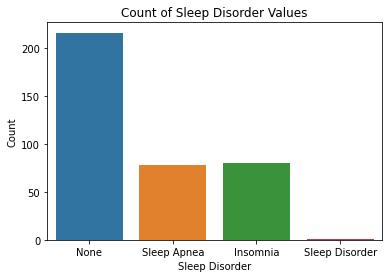

In [12]:
# Count of sleep disorder values
sleep_disorder_dist = df_1.groupBy("Sleep Disorder").agg(count("Sleep Disorder").alias("count"))
sleep_disorder_dist.show()
# Convert Spark df to a Pandas df
sleep_disorder_dist_pd = sleep_disorder_dist.toPandas()
# Create barplot
sns.barplot(x="Sleep Disorder", y="count", data=sleep_disorder_dist_pd)

# Add titles and labels
plt.title("Count of Sleep Disorder Values")
plt.xlabel("Sleep Disorder")
plt.ylabel("Count")


+-------------+-----+
| BMI Category|count|
+-------------+-----+
|Normal Weight|   21|
|   Overweight|  151|
|        Obese|   10|
| BMI Category|    1|
|       Normal|  192|
+-------------+-----+



Text(0, 0.5, 'Count')

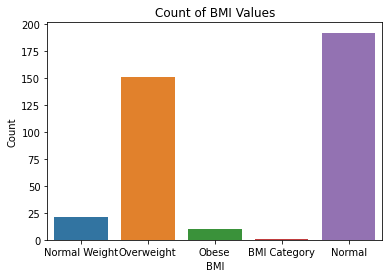

In [13]:
# Count of BMI values
bmi_dist = df_1.groupBy("BMI Category").agg(count("BMI Category").alias("count"))
bmi_dist.show()
# Convert Spark df to a Pandas df
bmi_dist_pd = bmi_dist.toPandas()
# Create barplot
sns.barplot(x="BMI Category", y="count", data=bmi_dist_pd)

# Add titles and labels
plt.title("Count of BMI Values")
plt.xlabel("BMI")
plt.ylabel("Count")

+--------------------+-----+
|          Occupation|count|
+--------------------+-----+
|           Scientist|    4|
|          Occupation|    1|
|               Nurse|   73|
|         Salesperson|   32|
|              Lawyer|   47|
|             Teacher|   40|
|Sales Representative|    2|
|              Doctor|   71|
|            Engineer|   63|
|          Accountant|   37|
|             Manager|    1|
|   Software Engineer|    4|
+--------------------+-----+

+--------------------+-----+-------------------+
|          Occupation|count|         percentage|
+--------------------+-----+-------------------+
|           Scientist|    4| 1.0666666666666667|
|          Occupation|    1|0.26666666666666666|
|               Nurse|   73| 19.466666666666665|
|         Salesperson|   32|  8.533333333333333|
|              Lawyer|   47| 12.533333333333333|
|             Teacher|   40| 10.666666666666668|
|Sales Representative|    2| 0.5333333333333333|
|              Doctor|   71| 18.9333333333333

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Scientist'),
  Text(1, 0, 'Occupation'),
  Text(2, 0, 'Nurse'),
  Text(3, 0, 'Salesperson'),
  Text(4, 0, 'Lawyer'),
  Text(5, 0, 'Teacher'),
  Text(6, 0, 'Sales Representative'),
  Text(7, 0, 'Doctor'),
  Text(8, 0, 'Engineer'),
  Text(9, 0, 'Accountant'),
  Text(10, 0, 'Manager'),
  Text(11, 0, 'Software Engineer')])

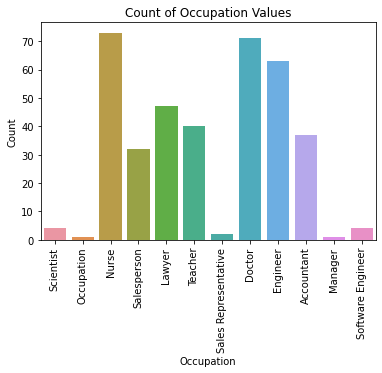

In [14]:
# Count of Occupation values
occ_dist = df_1.groupBy("Occupation").agg(count("Occupation").alias("count"))
occ_dist.show()
# Convert to percentage
occ_perc_dist = occ_dist.withColumn('percentage', (col('count') / df_1.count()) * 100)
occ_perc_dist.show()

# Convert Spark df to a Pandas df
occ_dist_pd = occ_dist.toPandas()
# Create barplot
sns.barplot(x="Occupation", y="count", data=occ_dist_pd)

# Add titles and labels
plt.title("Count of Occupation Values")
plt.xlabel("Occupation")
plt.ylabel("Count")
# Rotate them to vertical to make space for value labels
plt.xticks(rotation=90)

+--------------------+---------------------+
|          Occupation|Mean Quality of Sleep|
+--------------------+---------------------+
|           Scientist|                 2.75|
|          Occupation|                 null|
|               Nurse|     5.86986301369863|
|         Salesperson|              5.46875|
|              Lawyer|    6.382978723404255|
|             Teacher|               6.2125|
|Sales Representative|                  2.0|
|              Doctor|    6.112676056338028|
|            Engineer|    7.158730158730159|
|          Accountant|    7.202702702702703|
|             Manager|                  7.0|
|   Software Engineer|                5.625|
+--------------------+---------------------+



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Scientist'),
  Text(1, 0, 'Occupation'),
  Text(2, 0, 'Nurse'),
  Text(3, 0, 'Salesperson'),
  Text(4, 0, 'Lawyer'),
  Text(5, 0, 'Teacher'),
  Text(6, 0, 'Sales Representative'),
  Text(7, 0, 'Doctor'),
  Text(8, 0, 'Engineer'),
  Text(9, 0, 'Accountant'),
  Text(10, 0, 'Manager'),
  Text(11, 0, 'Software Engineer')])

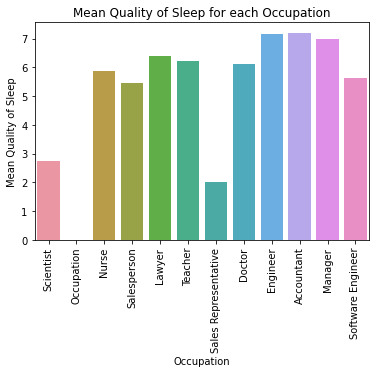

In [15]:
# Group by occupation and plot against mean of Quality of Sleep
occ_mean = df_1.groupBy("Occupation").agg(mean("Quality of Sleep").alias("Mean Quality of Sleep"))
occ_mean.show()

# Convert Spark df to a Pandas df
occ_mean_pd = occ_mean.toPandas()
# Create barplot
sns.barplot(x="Occupation", y="Mean Quality of Sleep", data=occ_mean_pd)

# Add titles and labels
plt.title("Mean Quality of Sleep for each Occupation")
plt.xlabel("Occupation")
plt.ylabel("Mean Quality of Sleep")
# Rotate them to vertical to make space for value labels
plt.xticks(rotation=90)

+-------------------------------+-----+
|Rounded Physical Activity Level|count|
+-------------------------------+-----+
|                          160.0|    1|
|                           70.0|   18|
|                            0.0|    3|
|                           null|    0|
|                           80.0|   22|
|                          120.0|    5|
|                          210.0|    1|
|                           50.0|   43|
|                          130.0|    1|
|                           60.0|   65|
|                           10.0|    2|
|                           40.0|   46|
|                           30.0|  100|
|                          100.0|    1|
|                           20.0|   42|
|                          150.0|    1|
|                           90.0|   22|
|                          110.0|    1|
+-------------------------------+-----+



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, '0.0'),
  Text(1, 0, '10.0'),
  Text(2, 0, '20.0'),
  Text(3, 0, '30.0'),
  Text(4, 0, '40.0'),
  Text(5, 0, '50.0'),
  Text(6, 0, '60.0'),
  Text(7, 0, '70.0'),
  Text(8, 0, '80.0'),
  Text(9, 0, '90.0'),
  Text(10, 0, '100.0'),
  Text(11, 0, '110.0'),
  Text(12, 0, '120.0'),
  Text(13, 0, '130.0'),
  Text(14, 0, '150.0'),
  Text(15, 0, '160.0'),
  Text(16, 0, '210.0')])

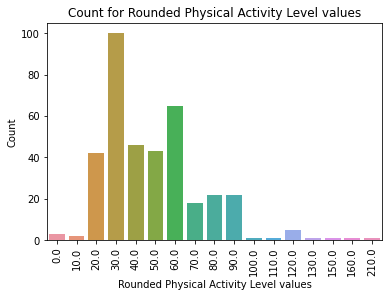

In [16]:
# Round of Physical Activity Level to allow column labels to be seen as there are too many distinct values
rounded_pal = df_1.withColumn('Rounded Physical Activity Level', round(df_1['Physical Activity Level'] / 10) * 10)
# Group by 'Rounded Physical Activity Level' and count
rounded_pal_dist = rounded_pal.groupBy('Rounded Physical Activity Level').agg(count('Rounded Physical Activity Level').alias('count'))
rounded_pal_dist.show()

# Convert Spark df to a Pandas df
rounded_pal_pd = rounded_pal_dist.toPandas()
# Create barplot
sns.barplot(x="Rounded Physical Activity Level", y="count", data=rounded_pal_pd)

# Add titles and labels
plt.title("Count for Rounded Physical Activity Level values")
plt.xlabel("Rounded Physical Activity Level values")
plt.ylabel("Count")
# Rotate them to vertical to make space for value labels
plt.xticks(rotation=90)

<AxesSubplot:xlabel='Physical Activity Level', ylabel='Density'>

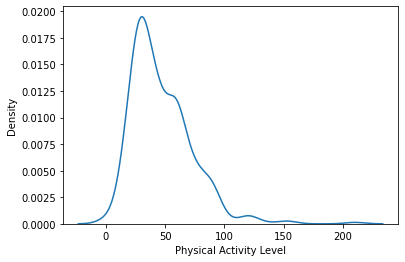

In [17]:
# Select Physical Activity Level and convert to pandas to plot
pal_df = df_1.select('Physical Activity Level').toPandas()
sns.kdeplot(data=pal_df, x='Physical Activity Level')


Text(16.299999999999997, 0.5, 'Quality of Sleep')

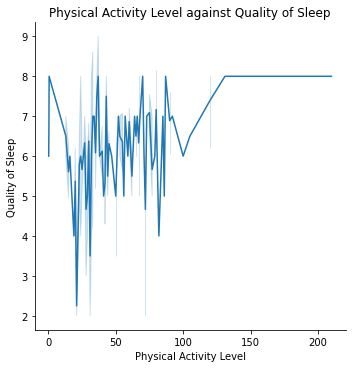

In [18]:
qol_pal_df = df_1.select('Quality of Sleep', 'Physical Activity Level').toPandas()
# Create barplot
sns.relplot(x="Physical Activity Level", y="Quality of Sleep", data=qol_pal_df, kind="line")

# Add titles and labels
plt.title("Physical Activity Level against Quality of Sleep")
plt.xlabel("Physical Activity Level")
plt.ylabel("Quality of Sleep")


-0.3313537991242806

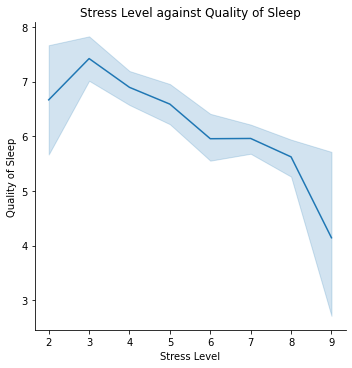

In [19]:
# Selecting the features for analysis
qol_stress_df = df_1.select('Quality of Sleep', 'Stress Level').toPandas()
# Create barplot
sns.relplot(x="Stress Level", y="Quality of Sleep", data=qol_stress_df, kind="line")

# Add titles and labels
plt.title("Stress Level against Quality of Sleep")
plt.xlabel("Stress Level")
plt.ylabel("Quality of Sleep")

# Finding the correlation
df_1.corr('Quality of Sleep', 'Stress Level')

+------------+-----+
|Stress Level|count|
+------------+-----+
|         9.0|    7|
|         5.0|   68|
|        null|    0|
|         7.0|   75|
|         2.0|    9|
|         3.0|   32|
|         6.0|   56|
|         8.0|   65|
|         4.0|   62|
+------------+-----+



(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, '2.0'),
  Text(1, 0, '3.0'),
  Text(2, 0, '4.0'),
  Text(3, 0, '5.0'),
  Text(4, 0, '6.0'),
  Text(5, 0, '7.0'),
  Text(6, 0, '8.0'),
  Text(7, 0, '9.0')])

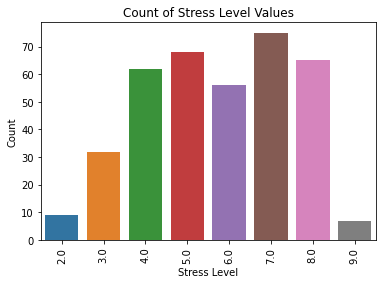

In [20]:
# Looking at distribution of stress level
stress_dist = df_1.groupBy("Stress Level").agg(count("Stress Level").alias("count"))
stress_dist.show()

# Convert Spark df to a Pandas df
stress_dist_pd = stress_dist.toPandas()
# Create barplot
sns.barplot(x="Stress Level", y="count", data=stress_dist_pd)

# Add titles and labels
plt.title("Count of Stress Level Values")
plt.xlabel("Stress Level")
plt.ylabel("Count")
# Rotate them to vertical to make space for value labels
plt.xticks(rotation=90)

+--------------------+---------------------+
|          Occupation|Mean Quality of Sleep|
+--------------------+---------------------+
|           Scientist|                 2.75|
|          Occupation|                 null|
|               Nurse|     5.86986301369863|
|         Salesperson|              5.46875|
|              Lawyer|    6.382978723404255|
|             Teacher|               6.2125|
|Sales Representative|                  2.0|
|              Doctor|    6.112676056338028|
|            Engineer|    7.158730158730159|
|          Accountant|    7.202702702702703|
|             Manager|                  7.0|
|   Software Engineer|                5.625|
+--------------------+---------------------+



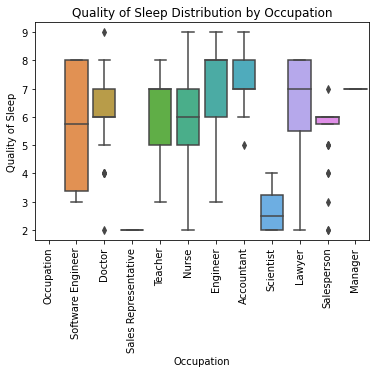

In [21]:
# Box plot of Quality of Sleep for each occupation
sns.boxplot(x='Occupation', y='Quality of Sleep', data=df_1.toPandas())
# Add titles and labels
plt.title('Quality of Sleep Distribution by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Quality of Sleep')
# Rotate them to vertical to make space for value labels
plt.xticks(rotation=90)

# Mean for each occupation
df_1.groupBy('Occupation').agg(mean('Quality of Sleep').alias('Mean Quality of Sleep')).show()


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'BMI Category'),
  Text(1, 0, 'Overweight'),
  Text(2, 0, 'Normal'),
  Text(3, 0, 'Obese'),
  Text(4, 0, 'Normal Weight')])

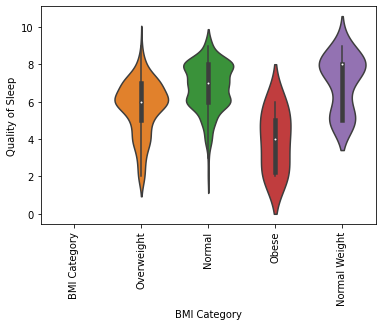

In [22]:
# Violin plot of Quality of Sleep for each BMI
sns.violinplot(x='BMI Category', y='Quality of Sleep', data=df_1.toPandas())
# Rotate them to vertical to make space for value labels
plt.xticks(rotation=90)

42
+-------+-----+
|Bedtime|count|
+-------+-----+
|   0:40|    4|
|   2:40|    1|
|   1:50|    2|
|   3:10|    1|
|   1:45|    2|
|   2:50|    1|
|  21:45|    1|
|   2:45|    1|
|  22:15|    1|
|  21:00|    4|
|   0:20|    2|
|   1:20|    4|
|  11:30|    2|
|  22:40|    3|
|   4:30|    1|
|   2:00|   17|
|  23:50|    5|
|   1:10|    2|
|  23:30|   42|
|  22:20|    1|
+-------+-----+
only showing top 20 rows



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 [Text(0, 0, '0:40'),
  Text(1, 0, '2:40'),
  Text(2, 0, '1:50'),
  Text(3, 0, '3:10'),
  Text(4, 0, '1:45'),
  Text(5, 0, '2:50'),
  Text(6, 0, '21:45'),
  Text(7, 0, '2:45'),
  Text(8, 0, '22:15'),
  Text(9, 0, '21:00'),
  Text(10, 0, '0:20'),
  Text(11, 0, '1:20'),
  Text(12, 0, '11:30'),
  Text(13, 0, '22:40'),
  Text(14, 0, '4:30'),
  Text(15, 0, '2:00'),
  Text(16, 0, '23:50'),
  Text(17, 0, '1:10'),
  Text(18, 0, '23:30'),
  Text(19, 0, '22:20'),
  Text(20, 0, '21:30'),
  Text(21, 0, '0:50'),
  Text(22, 0, '2:20'),
  Text(23, 0, '1:15'),
  Text(24, 0, '23:10'),
  Text(25, 0, '23:20'),
  Text(26, 0, '3:00'),
  Text(27, 0, '22:00'),
  Text(28, 0, '1:40'),
  Text(29, 0, '23:15'),
  Text(30, 0, '2:15'),
  Text(31, 0, '22:30'),
  Text(32, 0, '1:30'),
  Text(33, 0, '23:40'),
  Text(34, 0, '22:5

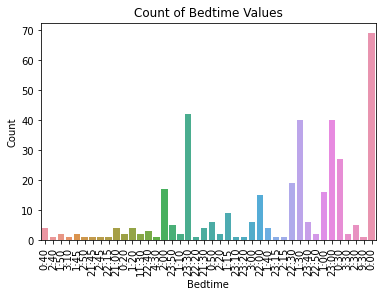

In [23]:
# Looking at distribution of bedtime
bt_dist = df_2.groupBy("Bedtime").agg(count("Bedtime").alias("count"))
# Number of unique values
print(bt_dist.count())
bt_dist.show()

# Convert Spark df to a Pandas df
bt_dist_pd = bt_dist.toPandas()
# Create barplot
sns.barplot(x="Bedtime", y="count", data=bt_dist_pd)

# Add titles and labels
plt.title("Count of Bedtime Values")
plt.xlabel("Bedtime")
plt.ylabel("Count")
# Rotate them to vertical to make space for value labels
plt.xticks(rotation=90)

## 2.4 Verifying Data Quality 

In [24]:
# Check for null values in each column
df_1.select([count(when(isnan(c), c)).alias(c) for c in df_1.columns]).show(truncate=False, vertical=True)
df_2.select([count(when(isnan(c), c)).alias(c) for c in df_2.columns]).show(truncate=False, vertical=True)


-RECORD 0----------------------
 PersonID                | 0   
 Gender                  | 0   
 Age                     | 0   
 Occupation              | 0   
 Sleep Duration          | 0   
 Quality of Sleep        | 0   
 Physical Activity Level | 0   
 Stress Level            | 0   
 BMI Category            | 0   
 Blood Pressure          | 0   
 Heart Rate              | 0   
 Daily Steps             | 6   
 Sleep Disorder          | 0   

-RECORD 0-----------
 Person ID    | 0   
 Bedtime      | 0   
 PhoneUse     | 0   
 WearsGlasses | 0   
 Religious    | 0   



+------+-----+
|Gender|count|
+------+-----+
|     F|    2|
|Female|  183|
|     M|    3|
|  Male|  186|
|Gender|    1|
+------+-----+



Text(0, 0.5, 'Count')

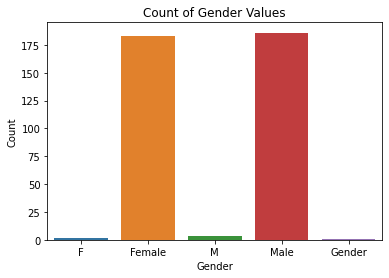

In [25]:
# Looking at distribution of genders
gender_dist = df_1.groupBy("Gender").agg(count("Gender").alias("count"))
gender_dist.show()

# Convert Spark df to a Pandas df
gender_dist_pd = gender_dist.toPandas()
# Create barplot
sns.barplot(x="Gender", y="count", data=gender_dist_pd)

# Add titles and labels
plt.title("Count of Gender Values")
plt.xlabel("Gender")
plt.ylabel("Count")


In [26]:
# Get values with decimal points (not .0) in Quality of Sleep
df_1.filter(col('Quality of Sleep') % 1 != 0).show()

+--------+------+----+-----------------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|PersonID|Gender| Age|       Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|
+--------+------+----+-----------------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|     1.0|  Male|27.0|Software Engineer|           6.1|             3.5|                   42.0|         6.0|  Overweight|        126/83|      77.0|     5200.0|          None|
|    91.0|  Male|35.0|         Engineer|           7.3|             7.5|                   60.0|         4.0|      Normal|        125/80|      65.0|     5000.0|          None|
|   134.0|Female|38.0|       Accountant|           7.1|             7.5|                   60.0|         4.0|      Norma

+----------+-----+
|Heart Rate|count|
+----------+-----+
|      82.0|    1|
|      86.0|    2|
|      null|    0|
|      67.0|    2|
|      70.0|   75|
|      72.0|   69|
|      65.0|   67|
|      85.0|    3|
|      68.0|   94|
|      77.0|    2|
|      83.0|    2|
|      78.0|    5|
|      80.0|    3|
|      76.0|    2|
|      88.0|    1|
|      69.0|    2|
|      45.0|    1|
|      81.0|    2|
|      84.0|    1|
|      73.0|    2|
+----------+-----+
only showing top 20 rows



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 [Text(0, 0, '45.0'),
  Text(1, 0, '65.0'),
  Text(2, 0, '67.0'),
  Text(3, 0, '68.0'),
  Text(4, 0, '69.0'),
  Text(5, 0, '70.0'),
  Text(6, 0, '72.0'),
  Text(7, 0, '73.0'),
  Text(8, 0, '74.0'),
  Text(9, 0, '75.0'),
  Text(10, 0, '76.0'),
  Text(11, 0, '77.0'),
  Text(12, 0, '78.0'),
  Text(13, 0, '80.0'),
  Text(14, 0, '81.0'),
  Text(15, 0, '82.0'),
  Text(16, 0, '83.0'),
  Text(17, 0, '84.0'),
  Text(18, 0, '85.0'),
  Text(19, 0, '86.0'),
  Text(20, 0, '88.0')])

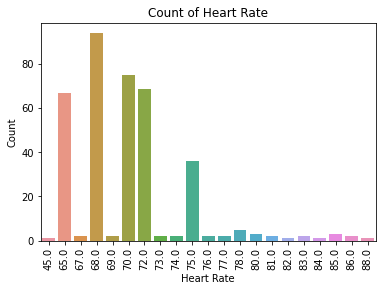

In [27]:
# Looking at distribution of heart rate
heart_rate_dist = df_1.groupBy("Heart Rate").agg(count("Heart Rate").alias("count"))
heart_rate_dist.show()

# Convert Spark df to a Pandas df
heart_rate_dist_pd = heart_rate_dist.toPandas()
# Create barplot
sns.barplot(x="Heart Rate", y="count", data=heart_rate_dist_pd)

# Add titles and labels
plt.title("Count of Heart Rate")
plt.xlabel("Heart Rate")
plt.ylabel("Count")
# Rotate them to vertical to make space for value labels
plt.xticks(rotation=90)

In [28]:
# Calculate mean and standard deviation of Heart Rate
mean_hr = df_1.select(mean(col("Heart Rate")).alias("mean_hr")).collect()[0]["mean_hr"]
sd_hr = df_1.select(stddev(col("Heart Rate")).alias("sd_hr")).collect()[0]["sd_hr"]

# Calculate z-score for Heart Rate
df_with_z_score = df_1.withColumn("z_score", abs((col("Heart Rate") - mean_hr) / sd_hr))

# Identify outliers as Heart Rate with a z-score greater than 3
z_threshold = 3
outliers = df_with_z_score.filter(col("z_score") > z_threshold)
outliers.show()

+--------+------+----+--------------------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+------------------+
|PersonID|Gender| Age|          Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|           z_score|
+--------+------+----+--------------------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+------------------+
|     4.0|  Male|28.0|Sales Representative|           5.9|             2.0|                   33.0|         8.0|       Obese|        140/90|      85.0|     2500.0|   Sleep Apnea|3.4037400672480294|
|     5.0|  Male|28.0|Sales Representative|           5.9|             2.0|                   31.0|         6.0|       Obese|        140/90|      85.0|     3000.0|   Sleep Apnea|3.4037400672480294|
|     6.0|

## 3.2 Cleaning Data

In [29]:
# Get values with NaN in Daily Steps
df_1.filter(col('Daily Steps') == 'NaN').show()

+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|PersonID|Gender| Age|Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|
+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|    21.0|  Male|30.0|    Doctor|           5.9|             7.0|                   60.0|         7.0|      Normal|        120/80|      70.0|        NaN|          None|
|    59.0|  Male|32.0|    Doctor|           6.0|             6.0|                   30.0|         8.0|      Normal|        125/80|      72.0|        NaN|          None|
|    64.0|  Male|32.0|    Doctor|           6.6|             6.0|                   55.0|         8.0|      Normal|        125/80|      72.0|        NaN|  

In [30]:
# Mean Physical Activity Level
mean_pal = df_1.select(mean(col("Physical Activity Level")).alias("mean_pal")).collect()[0]["mean_pal"]
print (mean_pal)

47.094652406512736


In [31]:
# Train linear model 
# Filter out rows where Daily Steps are not NaN to be used for training
df_filtered = df_1.filter(~isnan(col("Daily Steps")) & col("Daily Steps").isNotNull() & col("Physical Activity Level").isNotNull())

# Assemble feature vector
assembler = VectorAssembler(inputCols=["Physical Activity Level"], outputCol="feature")
df_filtered = assembler.transform(df_filtered)

# Train Linear Regression model
missing_linear_ds = LinearRegression(featuresCol="feature", labelCol="Daily Steps")
missing_linear_ds_model = missing_linear_ds.fit(df_filtered)

# Prepare DataFrame for prediction where Daily Steps is NaN to be used for predictions
df_missing_ds = df_1.filter(isnan(col("Daily Steps")) & col("Daily Steps").isNotNull() & col("Physical Activity Level").isNotNull())
df_missing_ds = assembler.transform(df_missing_ds)
df_missing_ds.show()

# Predict missing Daily Steps values into a prediction column and round them off to nearest integer
predictions = missing_linear_ds_model.transform(df_missing_ds)
predictions = predictions.withColumn("prediction", round(col("prediction")))
predictions.show()

# Join predictions with original DataFrame based on unique Participant ID
df_1_imp = df_1.join(predictions.select("PersonID", "prediction"), on="PersonID", how="left_outer")

# Replace Daily Steps values with predictions if there is any (should only be 6), otherwise keep original values
df_1_imp = df_1_imp.withColumn("Daily Steps", coalesce(col("prediction"), col("Daily Steps")))

# Find replaced values based on prediction column that is not null (hence predicted)
df_1_imp.filter(col("prediction").isNotNull()).show()

# Drop the prediction column as it's no longer needed
df_1_imp = df_1_imp.drop("prediction")

24/05/23 09:41:49 WARN Instrumentation: [d00f70bd] regParam is zero, which might cause numerical instability and overfitting.
24/05/23 09:41:49 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/23 09:41:49 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
24/05/23 09:41:49 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+-------+
|PersonID|Gender| Age|Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|feature|
+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+-------+
|    21.0|  Male|30.0|    Doctor|           5.9|             7.0|                   60.0|         7.0|      Normal|        120/80|      70.0|        NaN|          None| [60.0]|
|    59.0|  Male|32.0|    Doctor|           6.0|             6.0|                   30.0|         8.0|      Normal|        125/80|      72.0|        NaN|          None| [30.0]|
|    64.0|  Male|32.0|    Doctor|           6.6|             6.0|                   55.0|         8.0|      Normal|

In [32]:
# Look at first 25 rows
df_1_imp.show(25)

+--------+------+----+--------------------+--------------+----------------+-----------------------+------------+-------------+--------------+----------+-----------+--------------+
|PersonID|Gender| Age|          Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level| BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|
+--------+------+----+--------------------+--------------+----------------+-----------------------+------------+-------------+--------------+----------+-----------+--------------+
|    null|Gender|null|          Occupation|          null|            null|                   null|        null| BMI Category|Blood Pressure|      null|       null|Sleep Disorder|
|     1.0|  Male|27.0|   Software Engineer|           6.1|             3.5|                   42.0|         6.0|   Overweight|        126/83|      77.0|     5200.0|          None|
|     2.0|  Male|28.0|              Doctor|           6.2|             4.0|                   82.0| 

In [33]:
# Change Heart Rate value of 45 to 83
df_1_imp.filter(col("Heart Rate") == 45).show()
df_1_imp = df_1_imp.withColumn("Heart Rate", when(col("Heart Rate") == 45, 83).otherwise(col("Heart Rate")))
df_1_imp.filter(col("PersonID") == 146).show()


+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|PersonID|Gender| Age|Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|
+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|   146.0|Female|38.0|    Lawyer|           4.9|             2.0|                   25.0|         8.0|       Obese|        135/88|      45.0|     3300.0|   Sleep Apnea|
+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+

+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+-

In [34]:
# Locate all Physical Activity Level values lower than 1
low_pal = df_1_imp.filter(col("Physical Activity Level") < 1)
low_pal.show()

+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|PersonID|Gender| Age|Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|
+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|    47.0|  Male|31.0|    Doctor|           6.7|             7.0|                    0.5|         8.0|      Normal|        120/80|      70.0|     5000.0|          None|
|   112.0|  Male|37.0|    Lawyer|           7.4|             8.0|                    0.6|         8.0|      Normal|        130/85|      68.0|     2800.0|          None|
|   357.0|Female|58.0|     Nurse|           7.3|             6.0|                    0.3|         7.0|  Overweight|        140/95|      68.0|     5900.0|  

In [35]:
# Change Physical Activity Level from 0.5 to 60
df_1_imp.filter(col("Physical Activity Level") == 0.5).show()
df_1_imp = df_1_imp.withColumn("Physical Activity Level", when(col("Physical Activity Level") == 0.5, 60).otherwise(col("Physical Activity Level")))
df_1_imp.filter(col("PersonID") == 47).show()


+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|PersonID|Gender| Age|Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|
+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|    47.0|  Male|31.0|    Doctor|           6.7|             7.0|                    0.5|         8.0|      Normal|        120/80|      70.0|     5000.0|          None|
+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+

+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+-

In [36]:
# Locate all Physical Activity Level values lower than 1
low_pal = df_1_imp.filter(col("Physical Activity Level") < 1)
low_pal_values = low_pal.select("PersonID", "Physical Activity Level").collect()
print (low_pal_values[0][1])
print (low_pal_values[1][1])
# Show the rows where Physical Activity Level is lower than 1
low_pal.show()

0.6000000238418579
0.30000001192092896
+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|PersonID|Gender| Age|Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|
+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|   112.0|  Male|37.0|    Lawyer|           7.4|             8.0|                    0.6|         8.0|      Normal|        130/85|      68.0|     2800.0|          None|
|   357.0|Female|58.0|     Nurse|           7.3|             6.0|                    0.3|         7.0|  Overweight|        140/95|      68.0|     5900.0|   Sleep Apnea|
+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+-

In [37]:
# Replace the rest of the outliers less than 1
df_1_imp = df_1_imp.withColumn("Physical Activity Level", when(col("Physical Activity Level") == 0.6000000238418579, 60).otherwise(col("Physical Activity Level")))
df_1_imp = df_1_imp.withColumn("Physical Activity Level", when(col("Physical Activity Level") == 0.30000001192092896, 30).otherwise(col("Physical Activity Level")))
df_1_imp.filter((col("PersonID") == 112) | (col("PersonID") == 357)).show()


+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|PersonID|Gender| Age|Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|
+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|   112.0|  Male|37.0|    Lawyer|           7.4|             8.0|                   60.0|         8.0|      Normal|        130/85|      68.0|     2800.0|          None|
|   357.0|Female|58.0|     Nurse|           7.3|             6.0|                   30.0|         7.0|  Overweight|        140/95|      68.0|     5900.0|   Sleep Apnea|
+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--

In [38]:
# Get values with decimal points (not .0) in Quality of Sleep
float_qol_df = df_1_imp.filter(col('Quality of Sleep') % 1 != 0)
float_qol_df.show()
# Get all PersonIDs of those with float values
float_qol_ID = [row['PersonID'] for row in float_qol_df.select('PersonID').collect()]
# Round values to closest whole number
df_1_imp = df_1_imp.withColumn("Quality of Sleep", round(col("Quality of Sleep"), 0))
# Filter out those that were in float_qol_ID
df_1_imp.filter(col("PersonID").isin(float_qol_ID)).show()

+--------+------+----+-----------------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|PersonID|Gender| Age|       Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|
+--------+------+----+-----------------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|     1.0|  Male|27.0|Software Engineer|           6.1|             3.5|                   42.0|         6.0|  Overweight|        126/83|      77.0|     5200.0|          None|
|    91.0|  Male|35.0|         Engineer|           7.3|             7.5|                   60.0|         4.0|      Normal|        125/80|      65.0|     5000.0|          None|
|   134.0|Female|38.0|       Accountant|           7.1|             7.5|                   60.0|         4.0|      Norma

In [39]:
# Initial schema
df_1_imp.printSchema()
new_data_types = {
    "PersonID": IntegerType(),
    "Gender": StringType(),
    "Age": IntegerType(),
    "Occupation": StringType(),
    "Sleep Duration": FloatType(),
    "Quality of Sleep": IntegerType(),
    "Physical Activity Level": IntegerType(),
    "Stress Level": IntegerType(),
    "BMI Category": StringType(),
    "Blood Pressure": StringType(),
    "Heart Rate": IntegerType(),
    "Daily Steps": IntegerType(),
    "Sleep Disorder": StringType()
}

# Apply the data types to each column
for col_name, target_type in new_data_types.items():
    df_1_imp = df_1_imp.withColumn(col_name, df_1_imp[col_name].cast(target_type))
    
# New Schema
df_1_imp.printSchema()

root
 |-- PersonID: float (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: float (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Sleep Duration: float (nullable = true)
 |-- Quality of Sleep: float (nullable = true)
 |-- Physical Activity Level: float (nullable = true)
 |-- Stress Level: float (nullable = true)
 |-- BMI Category: string (nullable = true)
 |-- Blood Pressure: string (nullable = true)
 |-- Heart Rate: float (nullable = true)
 |-- Daily Steps: double (nullable = true)
 |-- Sleep Disorder: string (nullable = true)

root
 |-- PersonID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Sleep Duration: float (nullable = true)
 |-- Quality of Sleep: integer (nullable = true)
 |-- Physical Activity Level: integer (nullable = true)
 |-- Stress Level: integer (nullable = true)
 |-- BMI Category: string (nullable = true)
 |-- Blood Pressure: string (nu

## 3.3 Construct New Data

Text(0, 0.5, 'Count')

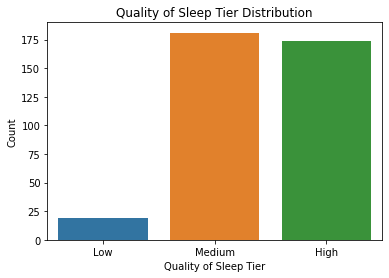

In [40]:
# Construct new column according to ranges
df_1_imp = df_1_imp.withColumn(
    "Quality_of_Sleep_Tier",
    when((col("Quality of Sleep") >= 1) & (col("Quality of Sleep") <= 3), "Low")
    .when((col("Quality of Sleep") >= 4) & (col("Quality of Sleep") <= 6), "Medium")
    .when((col("Quality of Sleep") >= 7) & (col("Quality of Sleep") <= 9), "High")
)
sns.countplot(data=df_1_imp.toPandas(), x='Quality_of_Sleep_Tier', order=["Low", "Medium", "High"])
# Add titles and labels
plt.title("Quality of Sleep Tier Distribution")
plt.xlabel("Quality of Sleep Tier")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

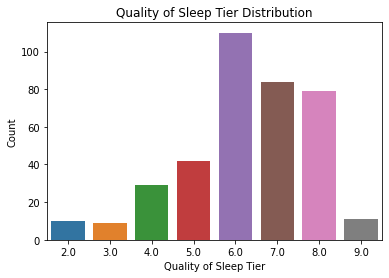

In [41]:
# Count plot of Quality of Sleep values
sns.countplot(data=df_1_imp.toPandas(), x='Quality of Sleep')
# Add titles and labels
plt.title("Quality of Sleep Tier Distribution")
plt.xlabel("Quality of Sleep Tier")
plt.ylabel("Count")

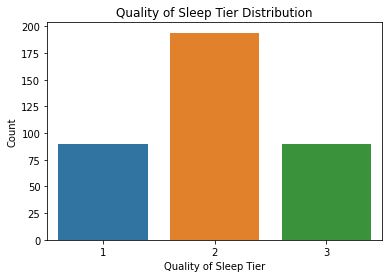

In [42]:
# Construct new column according to new ranges
df_1_imp = df_1_imp.withColumn(
    "Quality_of_Sleep_Tier",
    when((col("Quality of Sleep") <= 5), 1)
    .when((col("Quality of Sleep") >= 6) & (col("Quality of Sleep") <= 7), 2)
    .when((col("Quality of Sleep") >= 8), 3)
)
sns.countplot(data=df_1_imp.toPandas(), x='Quality_of_Sleep_Tier', order=[1, 2, 3])
# Add titles and labels
plt.title("Quality of Sleep Tier Distribution")
plt.xlabel("Quality of Sleep Tier")
plt.ylabel("Count")

# Convert to int"Quality_of_Sleep_Tier
df_1_imp = df_1_imp.withColumn("Quality_of_Sleep_Tier", col("Quality_of_Sleep_Tier").cast(IntegerType()))

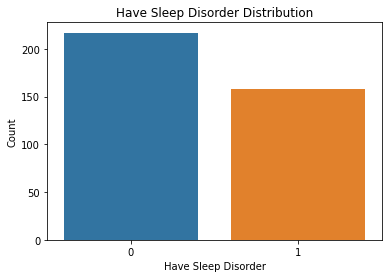

In [43]:
# Construct new column according to presence of sleep disorder values (sleep apnea and insomnia)
df_1_imp = df_1_imp.withColumn(
    "Have_Sleep_Disorder",
    when((col("Sleep Disorder") == "Insomnia") | (col("Sleep Disorder") == "Sleep Apnea"), 1)
    .otherwise(0)
)
sns.countplot(data=df_1_imp.toPandas(), x='Have_Sleep_Disorder')
# Add titles and labels
plt.title("Have Sleep Disorder Distribution")
plt.xlabel("Have Sleep Disorder")
plt.ylabel("Count")

# Convert to integer
df_1_imp = df_1_imp.withColumn("Have_Sleep_Disorder", col("Have_Sleep_Disorder").cast(IntegerType()))

In [44]:
# Change Y N values to 1 0 
df_2 = df_2.withColumn(
    "PhoneUse",
    when((col("PhoneUse") == "Y"), 1)
    .otherwise(0)
)
df_2.show()
df_2 = df_2.withColumn("PhoneUse", col("PhoneUse").cast(IntegerType()))

+---------+-------+--------+------------+---------+
|Person ID|Bedtime|PhoneUse|WearsGlasses|Religious|
+---------+-------+--------+------------+---------+
|        1|   1:00|       1|           Y|        Y|
|        2|   0:30|       0|           N|        Y|
|        3|   1:00|       1|           N|        Y|
|        4|   1:00|       1|           N|        Y|
|        5|   1:40|       1|           N|        Y|
|        6|   3:00|       1|           N|        Y|
|        7|   0:50|       1|           Y|        Y|
|        8|   2:50|       0|           N|        N|
|        9|   1:30|       1|           Y|        Y|
|       10|   3:30|       0|           Y|        Y|
|       11|   4:30|       0|           Y|        Y|
|       12|   3:00|       0|           Y|        N|
|       13|   2:00|       1|           N|        N|
|       14|   0:50|       1|           Y|        Y|
|       15|   3:00|       1|           N|        Y|
|       16|   2:20|       1|           Y|        Y|
|       17| 

In [45]:
# Do the same for the other boolean columns
df_2 = df_2.withColumn(
    "WearsGlasses",
    when((col("WearsGlasses") == "Y"), 1)
    .otherwise(0)
)
df_2 = df_2.withColumn(
    "Religious",
    when((col("Religious") == "Y"), 1)
    .otherwise(0)
)
df_2 = df_2.withColumn("WearsGlasses", col("WearsGlasses").cast(IntegerType()))
df_2 = df_2.withColumn("Religious", col("Religious").cast(IntegerType()))
df_2.show()

+---------+-------+--------+------------+---------+
|Person ID|Bedtime|PhoneUse|WearsGlasses|Religious|
+---------+-------+--------+------------+---------+
|        1|   1:00|       1|           1|        1|
|        2|   0:30|       0|           0|        1|
|        3|   1:00|       1|           0|        1|
|        4|   1:00|       1|           0|        1|
|        5|   1:40|       1|           0|        1|
|        6|   3:00|       1|           0|        1|
|        7|   0:50|       1|           1|        1|
|        8|   2:50|       0|           0|        0|
|        9|   1:30|       1|           1|        1|
|       10|   3:30|       0|           1|        1|
|       11|   4:30|       0|           1|        1|
|       12|   3:00|       0|           1|        0|
|       13|   2:00|       1|           0|        0|
|       14|   0:50|       1|           1|        1|
|       15|   3:00|       1|           0|        1|
|       16|   2:20|       1|           1|        1|
|       17| 

## 3.4 Integrating Data

In [46]:
# Rename column to allow for merge 
df_2 = df_2.withColumnRenamed("Person ID", "PersonID")
df_1_imp = df_1_imp.filter(col("PersonID").isNotNull())

# Join and merge the two dfs together
df_merged = df_1_imp.join(df_2, on="PersonID", how="inner")
# Drop it as it is no longer needed
df_merged = df_merged.drop("PersonID")
df_merged.show()



+------+---+--------------------+--------------+----------------+-----------------------+------------+-------------+--------------+----------+-----------+--------------+---------------------+-------------------+-------+--------+------------+---------+
|Gender|Age|          Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level| BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|Quality_of_Sleep_Tier|Have_Sleep_Disorder|Bedtime|PhoneUse|WearsGlasses|Religious|
+------+---+--------------------+--------------+----------------+-----------------------+------------+-------------+--------------+----------+-----------+--------------+---------------------+-------------------+-------+--------+------------+---------+
|  Male| 27|   Software Engineer|           6.1|               4|                     42|           6|   Overweight|        126/83|        77|       5200|          None|                    1|                  0|   1:00|       1|           1|   

In [47]:
# Unique blood pressure values
print(df_merged.select("Blood Pressure").distinct().count())


25


## 3.5 Formatting Data

In [48]:
# Before count
df_merged.groupBy("BMI Category").count().show()

# Changing Normal Weight to Normal
df_merged = df_merged.withColumn(
    "BMI Category",
    when(col("BMI Category") == "Normal Weight", "Normal")
    .otherwise(col("BMI Category"))
)

# After count
df_merged.groupBy("BMI Category").count().show()


+-------------+-----+
| BMI Category|count|
+-------------+-----+
|Normal Weight|   21|
|   Overweight|  151|
|        Obese|   10|
|       Normal|  192|
+-------------+-----+

+------------+-----+
|BMI Category|count|
+------------+-----+
|  Overweight|  151|
|       Obese|   10|
|      Normal|  213|
+------------+-----+



In [49]:
# Changing to numerical values
df_merged = df_merged.withColumn(
    "BMI Category",
    when(col("BMI Category") == "Normal", 1)
    .when(col("BMI Category") == "Overweight", 2)
    .when(col("BMI Category") == "Obese", 3)
)
df_merged = df_merged.withColumn("BMI Category", col("BMI Category").cast(IntegerType()))
df_merged.show()

+------+---+--------------------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+---------------------+-------------------+-------+--------+------------+---------+
|Gender|Age|          Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|Quality_of_Sleep_Tier|Have_Sleep_Disorder|Bedtime|PhoneUse|WearsGlasses|Religious|
+------+---+--------------------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+---------------------+-------------------+-------+--------+------------+---------+
|  Male| 27|   Software Engineer|           6.1|               4|                     42|           6|           2|        126/83|        77|       5200|          None|                    1|                  0|   1:00|       1|           1|       

In [50]:
# Before count
df_merged.groupBy("Gender").count().show()

# Changing M and F naming conventions
df_merged = df_merged.withColumn(
    "Gender",
    when(col("Gender") == "M", "Male")
    .when(col("Gender") == "F", "Female")
    .otherwise(col("Gender"))
)

# After count
df_merged.groupBy("Gender").count().show()

+------+-----+
|Gender|count|
+------+-----+
|     F|    2|
|Female|  183|
|     M|    3|
|  Male|  186|
+------+-----+

+------+-----+
|Gender|count|
+------+-----+
|Female|  185|
|  Male|  189|
+------+-----+



## 4.1 Data Reduction

In [51]:
low_qos = df_merged.filter(col("Quality_of_Sleep_Tier") == 1)
high_qos = df_merged.filter(col("Quality_of_Sleep_Tier") == 3)
print (low_qos.count())

# Union the boosted rows original to oversample it by 2x (original + itself again)
df_boosted = df_merged.union(low_qos).union(high_qos)
df_boosted.show()



90
+------+---+--------------------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+---------------------+-------------------+-------+--------+------------+---------+
|Gender|Age|          Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|Quality_of_Sleep_Tier|Have_Sleep_Disorder|Bedtime|PhoneUse|WearsGlasses|Religious|
+------+---+--------------------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+---------------------+-------------------+-------+--------+------------+---------+
|  Male| 27|   Software Engineer|           6.1|               4|                     42|           6|           2|        126/83|        77|       5200|          None|                    1|                  0|   1:00|       1|           1|    

554


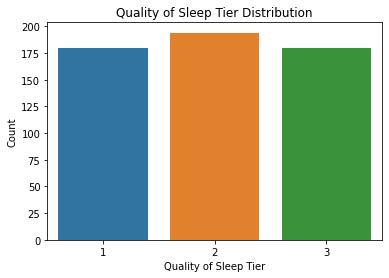

In [52]:
# Plot again
sns.countplot(data=df_boosted.toPandas(), x="Quality_of_Sleep_Tier", order=[1, 2, 3])
# Add titles and labels
plt.title("Quality of Sleep Tier Distribution")
plt.xlabel("Quality of Sleep Tier")
plt.ylabel("Count")

print (df_boosted.count())

<AxesSubplot:ylabel='Quality_of_Sleep_Tier'>

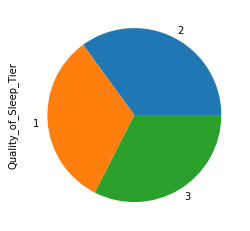

In [53]:
# Pie chart of Quality of Sleep Tier
df_boosted.toPandas()["Quality_of_Sleep_Tier"].value_counts().plot.pie()

+-------------------+-----+
|Have_Sleep_Disorder|count|
+-------------------+-----+
|                  1|  158|
|                  0|  216|
+-------------------+-----+

+-------------------+-----+
|Have_Sleep_Disorder|count|
+-------------------+-----+
|                  1|  223|
|                  0|  331|
+-------------------+-----+



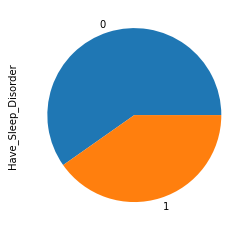

In [54]:
# Pie chart of Have Sleep Disorder
df_boosted.toPandas()['Have_Sleep_Disorder'].value_counts().plot.pie()
# Count distribution
# Before boost
df_1_imp.groupBy("Have_Sleep_Disorder").agg(count("Have_Sleep_Disorder").alias("count")).show()
# After oversampling
df_boosted.groupBy("Have_Sleep_Disorder").agg(count("Have_Sleep_Disorder").alias("count")).show()

+------+---+--------------------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+---------------------+-------------------+-------+--------+------------+---------+
|Gender|Age|          Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|Quality_of_Sleep_Tier|Have_Sleep_Disorder|Bedtime|PhoneUse|WearsGlasses|Religious|
+------+---+--------------------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+---------------------+-------------------+-------+--------+------------+---------+
|  Male| 27|   Software Engineer|           6.1|               4|                     42|           6|           2|        126/83|        77|       5200|          None|                    1|                  0|   1:00|       1|           1|       

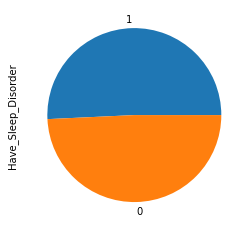

In [55]:
no_sd = df_boosted.filter(col("Have_Sleep_Disorder") == 0)
has_sd = df_boosted.filter(col("Have_Sleep_Disorder") == 1)

has_sd = has_sd.sample(withReplacement=True, fraction=0.5, seed=1)


# Union the boosted rows original to oversample it by 1.5x
df_boosted = df_boosted.union(has_sd)
df_boosted.show()

# Pie chart of Have Sleep Disorder
df_boosted.toPandas()["Have_Sleep_Disorder"].value_counts().plot.pie()
df_boosted.groupBy("Have_Sleep_Disorder").agg(count("Have_Sleep_Disorder").alias("count")).show()

In [56]:
# New sample size
df_boosted.count()

672

+---------------------+-----+
|Quality_of_Sleep_Tier|count|
+---------------------+-----+
|                    1|  232|
|                    3|  203|
|                    2|  237|
+---------------------+-----+



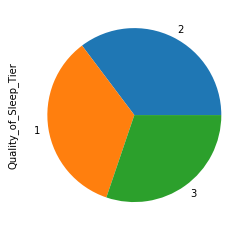

In [57]:
# Pie chart of Quality of Sleep Tier
df_boosted.toPandas()["Quality_of_Sleep_Tier"].value_counts().plot.pie()
df_boosted.groupBy("Quality_of_Sleep_Tier").agg(count("Quality_of_Sleep_Tier").alias("count")).show()

In [58]:
# Correlation between all numerical values
numerical_cols = [col_name for col_name, dtype in df_boosted.dtypes if dtype in ["int", "float"]]
correlations = []

# Loop through each pair of numerical columns to compute correlation
for i in range(len(numerical_cols)):
    for j in range(i + 1, len(numerical_cols)):
        col1 = numerical_cols[i]
        col2 = numerical_cols[j]
        correlation = df_boosted.select(corr(col1, col2)).collect()[0][0]
        correlations.append((col1, col2, correlation))

# Print out correlation values in readable format
for corr in correlations:
    print (corr)

('Age', 'Sleep Duration', 0.4161589747387926)
('Age', 'Quality of Sleep', 0.10730615088194201)
('Age', 'Physical Activity Level', -0.42614710983268284)
('Age', 'Stress Level', -0.14073067839227346)
('Age', 'BMI Category', 0.3527274663397378)
('Age', 'Heart Rate', -0.2873666447202671)
('Age', 'Daily Steps', -0.08131395210971268)
('Age', 'Quality_of_Sleep_Tier', 0.07820687045358299)
('Age', 'Have_Sleep_Disorder', 0.3841157710241609)
('Age', 'PhoneUse', 0.0918889598370971)
('Age', 'WearsGlasses', 0.14605539980017987)
('Age', 'Religious', -0.11895523365184818)
('Sleep Duration', 'Quality of Sleep', 0.5057099048126705)
('Sleep Duration', 'Physical Activity Level', 0.12249537335457424)
('Sleep Duration', 'Stress Level', -0.5684183705559667)
('Sleep Duration', 'BMI Category', -0.37559075402203346)
('Sleep Duration', 'Heart Rate', -0.5559896381451369)
('Sleep Duration', 'Daily Steps', 0.23452658927920653)
('Sleep Duration', 'Quality_of_Sleep_Tier', 0.45784188764281114)
('Sleep Duration', 'Have

In [59]:
df_boosted.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Sleep Duration: float (nullable = true)
 |-- Quality of Sleep: integer (nullable = true)
 |-- Physical Activity Level: integer (nullable = true)
 |-- Stress Level: integer (nullable = true)
 |-- BMI Category: integer (nullable = true)
 |-- Blood Pressure: string (nullable = true)
 |-- Heart Rate: integer (nullable = true)
 |-- Daily Steps: integer (nullable = true)
 |-- Sleep Disorder: string (nullable = true)
 |-- Quality_of_Sleep_Tier: integer (nullable = true)
 |-- Have_Sleep_Disorder: integer (nullable = false)
 |-- Bedtime: string (nullable = true)
 |-- PhoneUse: integer (nullable = false)
 |-- WearsGlasses: integer (nullable = false)
 |-- Religious: integer (nullable = false)



In [60]:
# Make a copy of df_boosted for correlation analysis
df_corr = df_boosted
df_corr = df_corr.drop("Quality of Sleep")
df_corr = df_corr.drop("Sleep Disorder")

# Identify numerical columns
numerical_cols = [col_name for col_name, col_type in df_corr.dtypes if col_type != "string"]

# Identify string categorical columns
string_categorical_cols = [col_name for col_name, col_type in df_corr.dtypes if col_type == "string"]

# Apply StringIndexer to string categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col+"_num", handleInvalid="keep").fit(df_corr) for col in string_categorical_cols]
for indexer in indexers:
    df_corr = indexer.transform(df_corr)
# Assemble features into a vector column to allow for corr() 
assembler = VectorAssembler(inputCols=[col+"_num" for col in string_categorical_cols] + numerical_cols, outputCol="features")
df_corr = assembler.transform(df_corr)
df_corr.show()

24/05/23 09:43:08 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------+---+--------------------+--------------+-----------------------+------------+------------+--------------+----------+-----------+---------------------+-------------------+-------+--------+------------+---------+----------+--------------+------------------+-----------+--------------------+
|Gender|Age|          Occupation|Sleep Duration|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Heart Rate|Daily Steps|Quality_of_Sleep_Tier|Have_Sleep_Disorder|Bedtime|PhoneUse|WearsGlasses|Religious|Gender_num|Occupation_num|Blood Pressure_num|Bedtime_num|            features|
+------+---+--------------------+--------------+-----------------------+------------+------------+--------------+----------+-----------+---------------------+-------------------+-------+--------+------------+---------+----------+--------------+------------------+-----------+--------------------+
|  Male| 27|   Software Engineer|           6.1|                     42|           6|           2|        126

In [61]:
# Correlation matrix
matrix = Correlation.corr(df_corr, "features")

# Extract correlation matrix as a numpy array
correlation_matrix = matrix.collect()[0]["pearson(features)"].toArray()
print (correlation_matrix.tolist())

# Convert correlation matrix to DataFrame for easier formatting
correlation_matrix_df = spark.createDataFrame(correlation_matrix.tolist(), numerical_cols + [col+"_num" for col in string_categorical_cols])
correlation_matrix_df.show(truncate=False, vertical=True)


/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[1.0, 0.2804847121148885, -0.05713480357629919, 0.03887415005695753, -0.5899923335063539, -0.2921475849355296, 0.40857326525996907, 0.2143110121976469, -0.1901085477168073, 0.21458348738922942, 0.14887953066486323, -0.028990826891642008, -0.2706153446081718, -0.1323420277313386, -0.14034272899849695, 0.06979028394888669], [0.2804847121148885, 1.0, 0.20034868984382007, 0.05680500517538903, -0.46197262882555007, -0.2780475727315165, 0.1350297310587332, -0.02168771377174176, 0.09845770902485355, 0.09971730560855131, -0.06307650269483073, -0.059899854762532484, -0.049057397540851595, -0.008378975623965206, -0.06833074422456988, 0.02826162404291154], [-0.05713480357629919, 0.20034868984382007, 1.0, -0.03033303169428059, -0.2707375749877828, -0.15608498492834963, 0.038108505604913134, -0.013974925271619474, 0.13397179391164793, 0.2502189390932617, -0.15681454170845194, -0.11540051973162706, -0.0906409979216033, 0.09704630183275212, -0.018712392268083515, 0.0907497230814882], [0.038874150056

-RECORD 0-----------------------------------------
 Age                     | 1.0                    
 Sleep Duration          | 0.2804847121148885     
 Physical Activity Level | -0.05713480357629919   
 Stress Level            | 0.03887415005695753    
 BMI Category            | -0.5899923335063539    
 Heart Rate              | -0.2921475849355296    
 Daily Steps             | 0.40857326525996907    
 Quality_of_Sleep_Tier   | 0.2143110121976469     
 Have_Sleep_Disorder     | -0.1901085477168073    
 PhoneUse                | 0.21458348738922942    
 WearsGlasses            | 0.14887953066486323    
 Religious               | -0.028990826891642008  
 Gender_num              | -0.2706153446081718    
 Occupation_num          | -0.1323420277313386    
 Blood Pressure_num      | -0.14034272899849695   
 Bedtime_num             | 0.06979028394888669    
-RECORD 1-----------------------------------------
 Age                     | 0.2804847121148885     
 Sleep Duration          | 1.0 

In [62]:
# Creating final df to hold our remaining features
df_final = df_boosted
df_final = df_final.drop("Quality of Sleep")
df_final = df_final.drop("Sleep Disorder")
df_final = df_final.drop("Religious")
df_final = df_final.drop("WearsGlasses")
df_final = df_final.drop("Heart Rate")
df_final.show()

+------+---+--------------------+--------------+-----------------------+------------+------------+--------------+-----------+---------------------+-------------------+-------+--------+
|Gender|Age|          Occupation|Sleep Duration|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Daily Steps|Quality_of_Sleep_Tier|Have_Sleep_Disorder|Bedtime|PhoneUse|
+------+---+--------------------+--------------+-----------------------+------------+------------+--------------+-----------+---------------------+-------------------+-------+--------+
|  Male| 27|   Software Engineer|           6.1|                     42|           6|           2|        126/83|       5200|                    1|                  0|   1:00|       1|
|  Male| 28|              Doctor|           6.2|                     82|           8|           1|        125/80|       8000|                    1|                  0|   0:30|       0|
|  Male| 28|              Doctor|           6.2|                     67|   

In [63]:
df_final.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Sleep Duration: float (nullable = true)
 |-- Physical Activity Level: integer (nullable = true)
 |-- Stress Level: integer (nullable = true)
 |-- BMI Category: integer (nullable = true)
 |-- Blood Pressure: string (nullable = true)
 |-- Daily Steps: integer (nullable = true)
 |-- Quality_of_Sleep_Tier: integer (nullable = true)
 |-- Have_Sleep_Disorder: integer (nullable = false)
 |-- Bedtime: string (nullable = true)
 |-- PhoneUse: integer (nullable = false)



In [64]:
# Count of unique values 
print(df_final.select("Bedtime").distinct().count())
print(df_final.select("Blood Pressure").distinct().count())
print(df_final.select("Occupation").distinct().count())


42
25
11


In [65]:
# Split Blood Pressure based on /
df_bp = df_final.withColumn("BP_Array", split(col("Blood Pressure"), "/"))

# Create Systolic and Diastolic columns from the array
df_bp = df_bp.withColumn("Systolic", col("BP_Array").getItem(0).cast("int"))
df_bp = df_bp.withColumn("Diastolic", col("BP_Array").getItem(1).cast("int"))

# Drop the array and Blood Pressure
df_bp = df_bp.drop("BP_Array")
df_bp = df_bp.drop("Blood Pressure")
df_bp.show()

+------+---+--------------------+--------------+-----------------------+------------+------------+-----------+---------------------+-------------------+-------+--------+--------+---------+
|Gender|Age|          Occupation|Sleep Duration|Physical Activity Level|Stress Level|BMI Category|Daily Steps|Quality_of_Sleep_Tier|Have_Sleep_Disorder|Bedtime|PhoneUse|Systolic|Diastolic|
+------+---+--------------------+--------------+-----------------------+------------+------------+-----------+---------------------+-------------------+-------+--------+--------+---------+
|  Male| 27|   Software Engineer|           6.1|                     42|           6|           2|       5200|                    1|                  0|   1:00|       1|     126|       83|
|  Male| 28|              Doctor|           6.2|                     82|           8|           1|       8000|                    1|                  0|   0:30|       0|     125|       80|
|  Male| 28|              Doctor|           6.2|       

In [66]:
# String index for Occupation
indexer = StringIndexer(inputCol="Occupation", outputCol="OccupationIndex")
df_occ = indexer.fit(df_bp).transform(df_bp)

# Apply OneHotEncoder to the indexed column
encoder = OneHotEncoder(inputCol="OccupationIndex", outputCol="OccupationVector")
df_occ = encoder.fit(df_occ).transform(df_occ)

# Drop the rest of the other columns
df_occ = df_occ.drop("OccupationIndex")
df_occ = df_occ.drop("Occupation")
df_occ.show()

df_bp.groupBy("Occupation").agg(count("Occupation").alias("count")).show()

+------+---+--------------+-----------------------+------------+------------+-----------+---------------------+-------------------+-------+--------+--------+---------+----------------+
|Gender|Age|Sleep Duration|Physical Activity Level|Stress Level|BMI Category|Daily Steps|Quality_of_Sleep_Tier|Have_Sleep_Disorder|Bedtime|PhoneUse|Systolic|Diastolic|OccupationVector|
+------+---+--------------+-----------------------+------------+------------+-----------+---------------------+-------------------+-------+--------+--------+---------+----------------+
|  Male| 27|           6.1|                     42|           6|           2|       5200|                    1|                  0|   1:00|       1|     126|       83|  (10,[7],[1.0])|
|  Male| 28|           6.2|                     82|           8|           1|       8000|                    1|                  0|   0:30|       0|     125|       80|  (10,[2],[1.0])|
|  Male| 28|           6.2|                     67|           8|           

In [67]:
occupation_dist = df_bp.groupBy("Occupation").agg(count("Occupation").alias("count"))

# Sort them such that they match the StringIndexer where most frequent occupation gets 0 etc.
sorted_occupations = occupation_dist.orderBy(desc("count")).collect()

# Create a dictionary mapping occupation values to indices
occupation_index_map = {row["Occupation"]: index for index, row in enumerate(sorted_occupations)}
print(occupation_index_map)

{'Nurse': 0, 'Engineer': 1, 'Doctor': 2, 'Lawyer': 3, 'Teacher': 4, 'Accountant': 5, 'Salesperson': 6, 'Software Engineer': 7, 'Scientist': 8, 'Sales Representative': 9, 'Manager': 10}


In [68]:
# Changing gender to just Male
df_occ = df_occ.withColumn("Gender", when(col("Gender") == "Male", 1).otherwise(0))
# Renaming it
df_occ = df_occ.withColumnRenamed("Gender", "Male")
df_occ = df_occ.withColumn("Male", col("Male").cast(IntegerType()))
df_occ.show()


+----+---+--------------+-----------------------+------------+------------+-----------+---------------------+-------------------+-------+--------+--------+---------+----------------+
|Male|Age|Sleep Duration|Physical Activity Level|Stress Level|BMI Category|Daily Steps|Quality_of_Sleep_Tier|Have_Sleep_Disorder|Bedtime|PhoneUse|Systolic|Diastolic|OccupationVector|
+----+---+--------------+-----------------------+------------+------------+-----------+---------------------+-------------------+-------+--------+--------+---------+----------------+
|   1| 27|           6.1|                     42|           6|           2|       5200|                    1|                  0|   1:00|       1|     126|       83|  (10,[7],[1.0])|
|   1| 28|           6.2|                     82|           8|           1|       8000|                    1|                  0|   0:30|       0|     125|       80|  (10,[2],[1.0])|
|   1| 28|           6.2|                     67|           8|           1|       600

## 4.2 Data Projection

/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Density Distribution of Sleep Duration')

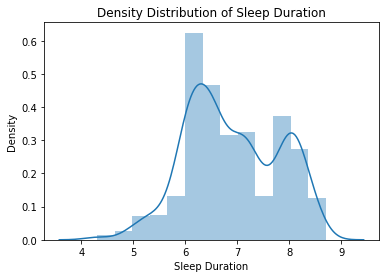

In [69]:
sns.distplot(df_occ.toPandas()['Sleep Duration'])
plt.title("Density Distribution of Sleep Duration")

/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Density Distribution of Physical Activity Level')

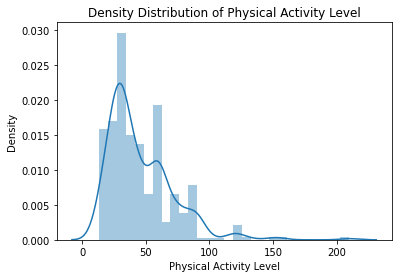

In [70]:
sns.distplot(df_occ.toPandas()['Physical Activity Level'])
plt.title("Density Distribution of Physical Activity Level")

/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Density Distribution of Daily Steps')

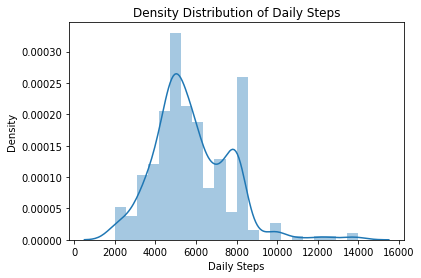

In [71]:
sns.distplot(df_occ.toPandas()['Daily Steps'])
plt.title("Density Distribution of Daily Steps")

/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Density Distribution of Physical Activity Level Log')

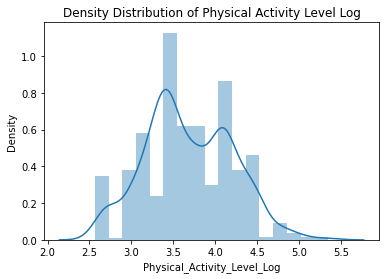

In [72]:
# Log them and create new column
df_occ = df_occ.withColumn("Physical_Activity_Level_Log", log(col("Physical Activity Level")))
df_occ = df_occ.withColumn("Daily_Steps_Log", log(col("Daily Steps")))
sns.distplot(df_occ.toPandas()['Physical_Activity_Level_Log'])
plt.title("Density Distribution of Physical Activity Level Log")

/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Density Distribution of Daily Steps Log')

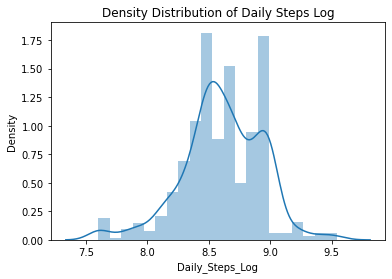

In [73]:
sns.distplot(df_occ.toPandas()['Daily_Steps_Log'])
plt.title("Density Distribution of Daily Steps Log")

In [74]:
print(df_occ.count())
print(len(df_occ.columns))

672
16


## 6.3 Build model with selected parameter(s)


In [75]:
from pyspark.ml.classification import (RandomForestClassifier, GBTClassifier, DecisionTreeClassifier)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Drop string and log'd columns
df_rf = df_occ.drop("Bedtime")
df_rf = df_rf.drop("Daily Steps")
df_rf = df_rf.drop("Physical Activity Level")


# Get every column other than target label
X_qos = [col for col in df_rf.columns if col != "Quality_of_Sleep_Tier"]

# Transform to features
rf_qos_assembler = VectorAssembler(inputCols=X_qos, outputCol="features")
df_rf_qos = rf_qos_assembler.transform(df_rf)

# Split to train and test
qos_train, qos_test = df_rf_qos.randomSplit([0.7, 0.3], seed=1)

# Build model
rf_qos = RandomForestClassifier(featuresCol="features", labelCol="Quality_of_Sleep_Tier")
rf_qos_model = rf_qos.fit(qos_train)

# Predict
rf_qos_pred = rf_qos_model.transform(qos_test)

rf_qos_pred.show()




+----+---+--------------+------------+------------+---------------------+-------------------+--------+--------+---------+----------------+---------------------------+-----------------+--------------------+--------------------+--------------------+----------+
|Male|Age|Sleep Duration|Stress Level|BMI Category|Quality_of_Sleep_Tier|Have_Sleep_Disorder|PhoneUse|Systolic|Diastolic|OccupationVector|Physical_Activity_Level_Log|  Daily_Steps_Log|            features|       rawPrediction|         probability|prediction|
+----+---+--------------+------------+------------+---------------------+-------------------+--------+--------+---------+----------------+---------------------------+-----------------+--------------------+--------------------+--------------------+----------+
|   0| 31|           7.0|           4|           1|                    3|                  0|       1|     117|       76|  (10,[0],[1.0])|         3.4965075614664802|8.517193191416238|(21,[1,2,3,4,6,7,...|[0.0,4.5640978917.

In [76]:
# Get every column other than target label
X_sd = [col for col in df_rf.columns if col != "Have_Sleep_Disorder"]

# Transform to features
rf_sd_assembler = VectorAssembler(inputCols=X_sd, outputCol="features")
df_rf_sd = rf_sd_assembler.transform(df_rf)

# Split to train and test
sd_train, sd_test = df_rf_sd.randomSplit([0.7, 0.3], seed=1)

# Build model
rf_sd = RandomForestClassifier(featuresCol="features", labelCol="Have_Sleep_Disorder")
rf_sd_model = rf_sd.fit(sd_train)

rf_sd_pred = rf_sd_model.transform(sd_test)

rf_sd_pred.show()

+----+---+--------------+------------+------------+---------------------+-------------------+--------+--------+---------+----------------+---------------------------+-----------------+--------------------+--------------------+--------------------+----------+
|Male|Age|Sleep Duration|Stress Level|BMI Category|Quality_of_Sleep_Tier|Have_Sleep_Disorder|PhoneUse|Systolic|Diastolic|OccupationVector|Physical_Activity_Level_Log|  Daily_Steps_Log|            features|       rawPrediction|         probability|prediction|
+----+---+--------------+------------+------------+---------------------+-------------------+--------+--------+---------+----------------+---------------------------+-----------------+--------------------+--------------------+--------------------+----------+
|   0| 31|           7.0|           4|           1|                    3|                  0|       1|     117|       76|  (10,[0],[1.0])|         3.4965075614664802|8.517193191416238|(21,[1,2,3,4,5,6,...|[19.1246875382130.

In [77]:
# Feature importance of model
rf_qos_model.featureImportances

SparseVector(21, {0: 0.0096, 1: 0.1176, 2: 0.2352, 3: 0.0783, 4: 0.0825, 5: 0.018, 6: 0.0176, 7: 0.0389, 8: 0.0642, 9: 0.0128, 10: 0.0374, 11: 0.0157, 12: 0.0165, 13: 0.0007, 14: 0.0035, 15: 0.0016, 16: 0.0012, 17: 0.0006, 19: 0.0795, 20: 0.1686})

### Feature Importance: Quality of Sleep Tier

In [78]:
expanded_features = []
# Get occupation values as occupation_index_map is occupation:index 
occupation_values = list(occupation_index_map.keys())
# Loop through each feature in X_qos that already extracted the feature names
for feature in X_qos:
    # However, if it is OccupationVector it will go through occupation_values and include them in order
    if feature == "OccupationVector":
        # Only n - 1 categories as last occupation Manager is not included in One Hot Encoding
        for i in range(len(occupation_index_map) - 1):
            expanded_features.append(f"{occupation_values[i]}")
    else:
        expanded_features.append(feature)
# Get the feature importance values
qos_importances = rf_qos_model.featureImportances
# Map the feature name to the value
feature_importances = {expanded_features[i]: importance for i, importance in enumerate(qos_importances)}
# Sort the importance values in descending order
feature_importances = sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)
for feature, importance in feature_importances:
    print(f"{feature}: {importance}")


Sleep Duration: 0.23516307659424865
Daily_Steps_Log: 0.16860479856496008
Age: 0.11762565361728708
BMI Category: 0.0825149964443117
Physical_Activity_Level_Log: 0.07951393195682951
Stress Level: 0.07828820881420485
Diastolic: 0.06418254108525305
Systolic: 0.03894427181951761
Engineer: 0.03744286328825537
Have_Sleep_Disorder: 0.01796990092939284
PhoneUse: 0.01757390933676884
Lawyer: 0.01646409178296853
Doctor: 0.01565957086750052
Nurse: 0.012818098047709137
Male: 0.009570337330706946
Accountant: 0.00353269104210409
Salesperson: 0.0016142773030926414
Software Engineer: 0.0012383986055712858
Teacher: 0.0006831082957533376
Scientist: 0.0005952742735640025
Sales Representative: 0.0


### Feature Importance: Have Sleep Disorder

In [79]:
expanded_features_sd = []
# Loop through each feature in X_qos that already extracted the feature names
for feature in X_sd:
    # However, if it is OccupationVector it will go through occupation_values and include them in order
    if feature == "OccupationVector":
        # Only n - 1 categories as last occupation Manager is not included in One Hot Encoding
        for i in range(len(occupation_index_map) - 1):
            expanded_features_sd.append(f"{occupation_values[i]}")
    else:
        expanded_features_sd.append(feature)
# Get the feature importance values
importances_sd = rf_sd_model.featureImportances
# Map the feature name to the value
feature_importances_sd = {expanded_features_sd[i]: importance for i, importance in enumerate(importances_sd)}
# Sort the importance values in descending order
feature_importances_sd = sorted(feature_importances_sd.items(), key=lambda item: item[1], reverse=True)
for feature, importance in feature_importances_sd:
    print(f"{feature}: {importance}")


BMI Category: 0.37552103215322485
Systolic: 0.2103416569371849
Diastolic: 0.117589934347836
Physical_Activity_Level_Log: 0.08187482858006649
Age: 0.03107217065803366
Daily_Steps_Log: 0.0306840139410574
Male: 0.027023930925455204
Sleep Duration: 0.025421098767571593
Nurse: 0.025295800700425572
Lawyer: 0.017318298123016943
Salesperson: 0.015222711812408704
Stress Level: 0.014705214984385085
Quality_of_Sleep_Tier: 0.008071492049284326
Engineer: 0.007456363663429571
PhoneUse: 0.0035705916342081943
Doctor: 0.0032468630192320483
Scientist: 0.002603458672423947
Teacher: 0.0015647232139379694
Software Engineer: 0.0009681381972324449
Accountant: 0.0004476776195852031
Sales Representative: 0.0


### K-means

In [80]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

km_assembler = VectorAssembler(inputCols=df_rf.columns, outputCol="features")
df_km = km_assembler.transform(df_rf)

# List to sum of squared distances within cluster
wcss = []
# List of silhouette scores
silhouette_scores = []

# Try different values of k (2-10)
for k in range(2, 11):
    km = KMeans(featuresCol="features", k=k, seed=1)
    km_model = km.fit(df_km)
    # Equivalent to WCSS
    cost = km_model.summary.trainingCost
    wcss.append(cost)
    # Finding silhouette score by assinging cluster
    km_pred = km_model.transform(df_km)
    # Evaluating it using ClusteringEvaluator
    evaluator = ClusteringEvaluator(featuresCol="features")
    ss = evaluator.evaluate(km_pred)
    silhouette_scores.append(ss)



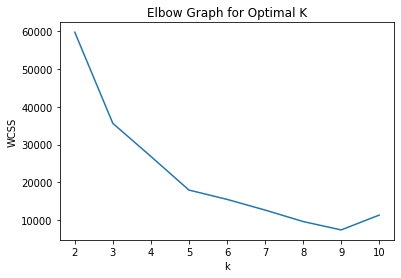

In [81]:
# Plot elbow curve
plt.plot(range(2, 11), wcss)
plt.title('Elbow Graph for Optimal K')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.show()

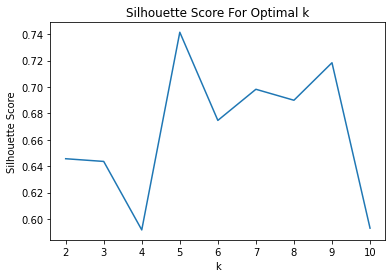

In [82]:
# Plot for Silhouette score
plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Score For Optimal k')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.show()

In [83]:
optimal_k = 5

# Build model with the optimal k
km = KMeans(featuresCol="features", k=optimal_k, seed=1)
km_model = km.fit(df_km)

# Add cluster predictions to the DataFrame
df_km = km_model.transform(df_km)

# Show clusters
df_km.select("features", "prediction").show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|(22,[0,1,2,3,4,5,...|         1|
|(22,[0,1,2,3,4,5,...|         3|
|(22,[0,1,2,3,4,5,...|         3|
|(22,[0,1,2,3,4,5,...|         1|
|(22,[0,1,2,3,4,5,...|         1|
|(22,[0,1,2,3,4,5,...|         1|
|(22,[0,1,2,3,4,5,...|         1|
|(22,[0,1,2,3,4,5,...|         3|
|(22,[0,1,2,3,4,5,...|         3|
|(22,[0,1,2,3,4,5,...|         3|
|(22,[0,1,2,3,4,5,...|         3|
|(22,[0,1,2,3,4,5,...|         3|
|(22,[0,1,2,3,4,5,...|         3|
|(22,[0,1,2,3,4,5,...|         3|
|(22,[0,1,2,3,4,5,...|         3|
|(22,[0,1,2,3,4,5,...|         3|
|(22,[1,2,3,4,5,6,...|         1|
|(22,[0,1,2,3,4,5,...|         3|
|(22,[1,2,3,4,5,6,...|         1|
|(22,[0,1,2,3,4,5,...|         3|
+--------------------+----------+
only showing top 20 rows



## 7.1 Create and justify test designs

In [84]:
# Dimesion of df
print(df_rf.count())
print(len(df_rf.columns))
print (qos_train.count(), qos_test.count())
print (sd_train.count(), sd_test.count())

672
13
456 216
456 216


## 7.2 Data mining must be conducted

### Random Forest: Quality of Sleep Tier

In [85]:
# Evaluating Quality of Sleep Tier
evaluator_qos = MulticlassClassificationEvaluator(labelCol="Quality_of_Sleep_Tier", predictionCol="prediction", metricName="accuracy")
# A test error of zero means that the model accuracy is at 100%. 
accuracy = evaluator_qos.evaluate(rf_qos_pred)
print ("Model 1: Quality of Sleep Tier")
print("Test Error = %g" % (1.0 - accuracy))
print ("Accuracy = %g" % accuracy)

Model 1: Quality of Sleep Tier
Test Error = 0.291667
Accuracy = 0.708333


In [86]:
from pyspark.mllib.evaluation import MulticlassMetrics
# Select both prediction and actual column
result_qos = rf_qos_pred.select("prediction", "Quality_of_Sleep_Tier")
# Have to convert to Double for confusionMatrix
result_qos = result_qos.withColumn("Quality_of_Sleep_Tier", col("Quality_of_Sleep_Tier").cast(DoubleType()))
# Cast RDD and map to tuple 
result_qos = MulticlassMetrics(result_qos.rdd.map(tuple))
cm_result_qos = result_qos.confusionMatrix().toArray()
print (cm_result_qos)

# Converting to percentage
total_samples = (cm_result_qos).sum(axis=1)
cm_percent = ((cm_result_qos / total_samples) * 100).round(2)
print (cm_percent)


/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[36. 17. 18.]
 [14. 46. 11.]
 [ 0.  3. 71.]]
[[50.7  23.94 24.32]
 [19.72 64.79 14.86]
 [ 0.    4.23 95.95]]


In [87]:
# Evaluation metrics for Quality of Sleep Tier
for i in range(1, 4):
    print (f"Precision score for {i}: {result_qos.precision(i)}")
    print (f"Recall score for {i}: {result_qos.recall(i)}")
    print (f"F1 score for {i}: {result_qos.fMeasure(float(i))}")


Precision score for 1: 0.72
Recall score for 1: 0.5070422535211268
F1 score for 1: 0.5950413223140496
Precision score for 2: 0.696969696969697
Recall score for 2: 0.647887323943662
F1 score for 2: 0.6715328467153285
Precision score for 3: 0.71
Recall score for 3: 0.9594594594594594
F1 score for 3: 0.8160919540229885


### Random Forest: Have Sleep Disorder

In [88]:
# Evaluating Have Sleep Disorder
evaluator_sd = MulticlassClassificationEvaluator(labelCol="Have_Sleep_Disorder", predictionCol="prediction", metricName="accuracy")
# A test error of zero means that the model accuracy is at 100%. 
accuracy = evaluator_sd.evaluate(rf_sd_pred)
print ("Model 1: Have Sleep Disorder")
print("Test Error = %g" % (1.0 - accuracy))
print ("Accuracy = %g" % accuracy)

Model 1: Have Sleep Disorder
Test Error = 0.087963
Accuracy = 0.912037


In [89]:
# Select both prediction and actual column
result_sd = rf_sd_pred.select("prediction", "Have_Sleep_Disorder")
# Have to convert to Double for confusionMatrix
result_sd = result_sd.withColumn("Have_Sleep_Disorder", col("Have_Sleep_Disorder").cast(DoubleType()))
# Cast RDD and map to tuple 
result_sd = MulticlassMetrics(result_sd.rdd.map(tuple))
cm_result_sd = result_sd.confusionMatrix().toArray()
print (cm_result_sd)

# Converting to percentage
total_samples_sd = (cm_result_sd).sum(axis=1)
cm_percent_sd = ((cm_result_sd / total_samples_sd) * 100).round(2)
print (cm_percent_sd)


[[104.   4.]
 [ 15.  93.]]
[[96.3   3.7 ]
 [13.89 86.11]]


In [90]:
# Evaluation metrics for Have Sleep Disorder
for i in range(0, 2):
    print (f"Precision score for {i}: {result_sd.precision(i)}")
    print (f"Recall score for {i}: {result_sd.recall(i)}")
    print (f"F1 score for {i}: {result_sd.fMeasure(float(i))}")


Precision score for 0: 0.8739495798319328
Recall score for 0: 0.9629629629629629
F1 score for 0: 0.9162995594713657
Precision score for 1: 0.9587628865979382
Recall score for 1: 0.8611111111111112
F1 score for 1: 0.9073170731707317


### K-means

In [91]:
# Distribution of cluster values
df_km.groupBy("prediction").agg(count("prediction").alias("count")).show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   35|
|         3|  173|
|         4|   75|
|         2|  162|
|         0|  227|
+----------+-----+



In [92]:
expanded_features_km = []
# Loop through each feature in all features for k-means
for feature in df_rf.columns:
    # However, if it is OccupationVector it will go through occupation_values and include them in order
    if feature == "OccupationVector":
        # Only n - 1 categories as last occupation Manager is not included in One Hot Encoding
        for i in range(len(occupation_index_map) - 1):
            expanded_features_km.append(f"{occupation_values[i]}")
    else:
        expanded_features_km.append(feature)
km_centres = km_model.clusterCenters() 
print("Cluster centres:") 
i = 1
for centre in km_centres: 
    print (f"Cluster {i}")
    i += 1
    # Print out each center value for features in cluster
    cluster_features = {expanded_features_km[i]: cluster_centre for i, cluster_centre in enumerate(centre)}
    for feature in cluster_features:
        print (feature, cluster_features[feature])
    print ("\n")

Cluster centres:
Cluster 1
Male 0.7533039647577093
Age 41.7488986784141
Sleep Duration 6.6511013308285625
Stress Level 5.682819383259912
BMI Category 1.563876651982379
Quality_of_Sleep_Tier 1.8722466960352424
Have_Sleep_Disorder 0.5726872246696035
PhoneUse 0.696035242290749
Systolic 130.91189427312776
Diastolic 85.96035242290749
Nurse 0.004405286343612335
Engineer 0.15418502202643172
Doctor 0.0
Lawyer 0.3480176211453745
Teacher 0.2643171806167401
Accountant 0.0
Salesperson 0.2246696035242291
Software Engineer 0.0
Scientist 0.0
Sales Representative 0.0
Physical_Activity_Level_Log 3.8073641586300786
Daily_Steps_Log 8.65772865344261


Cluster 2
Male 0.42857142857142855
Age 30.17142857142857
Sleep Duration 6.125714342934745
Stress Level 6.714285714285714
BMI Category 2.0285714285714285
Quality_of_Sleep_Tier 1.0
Have_Sleep_Disorder 0.8285714285714285
PhoneUse 0.8857142857142857
Systolic 133.4857142857143
Diastolic 87.28571428571428
Nurse 0.34285714285714286
Engineer 0.0
Doctor 0.0
Lawyer 0.

In [93]:
cluster_summary = df_km.groupBy("prediction").mean()
cluster_summary.show(truncate=False, vertical=True)

-RECORD 0-----------------------------------------------
 prediction                       | 1                   
 avg(Male)                        | 0.42857142857142855 
 avg(Age)                         | 30.17142857142857   
 avg(Sleep Duration)              | 6.125714342934745   
 avg(Stress Level)                | 6.714285714285714   
 avg(BMI Category)                | 2.0285714285714285  
 avg(Quality_of_Sleep_Tier)       | 1.0                 
 avg(Have_Sleep_Disorder)         | 0.8285714285714286  
 avg(PhoneUse)                    | 0.8857142857142857  
 avg(Systolic)                    | 133.4857142857143   
 avg(Diastolic)                   | 87.28571428571429   
 avg(Physical_Activity_Level_Log) | 3.5505959344866156  
 avg(Daily_Steps_Log)             | 8.12195522824206    
 avg(prediction)                  | 1.0                 
-RECORD 1-----------------------------------------------
 prediction                       | 3                   
 avg(Male)                     

/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of BMI Category in Cluster 4')

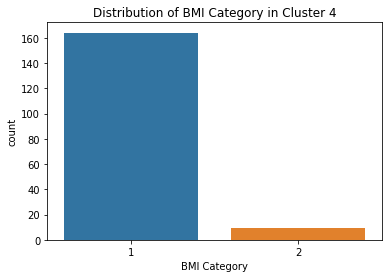

In [94]:
# Only take cluster 4
df_km_c4 = df_km.filter(df_km.prediction == 3)
sns.countplot(df_km_c4.toPandas()['BMI Category'])
plt.title("Distribution of BMI Category in Cluster 4")


/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of BMI Category in Cluster 5')

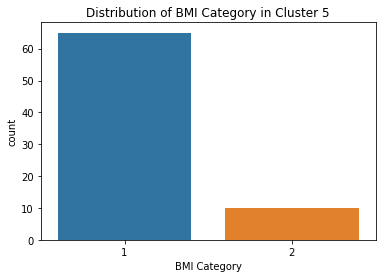

In [95]:
# Only take cluster 5
df_km_c5 = df_km.filter(df_km.prediction == 4)
sns.countplot(df_km_c5.toPandas()['BMI Category'])
plt.title("Distribution of BMI Category in Cluster 5")


/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of Stress Level in Cluster 4')

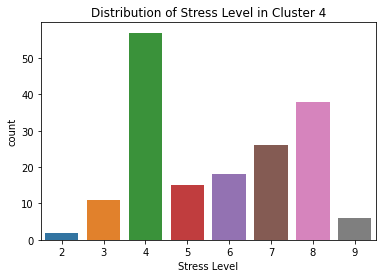

In [96]:
sns.countplot(df_km_c4.toPandas()['Stress Level'])
plt.title("Distribution of Stress Level in Cluster 4")


/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of Stress Level in Cluster 5')

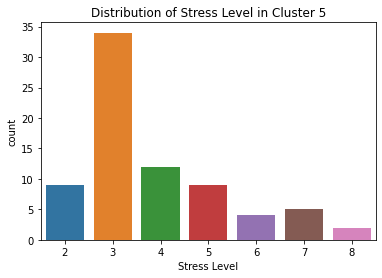

In [97]:
sns.countplot(df_km_c5.toPandas()['Stress Level'])
plt.title("Distribution of Stress Level in Cluster 5")


/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of Systolic in Cluster 4')

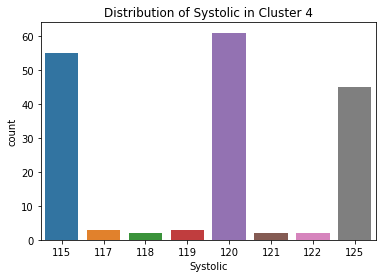

In [98]:
sns.countplot(df_km_c4.toPandas()['Systolic'])
plt.title("Distribution of Systolic in Cluster 4")


/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of Diastolic in Cluster 4')

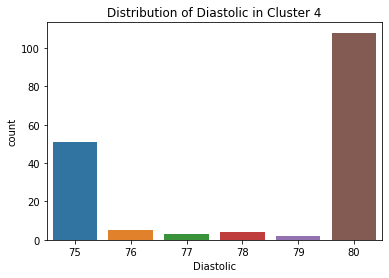

In [99]:
sns.countplot(df_km_c4.toPandas()['Diastolic'])
plt.title("Distribution of Diastolic in Cluster 4")

In [100]:
occupation_index_map = {'Nurse': 0, 'Engineer': 1, 'Doctor': 2, 'Lawyer': 3, 'Teacher': 4, 'Accountant': 5, 'Salesperson': 6, 'Software Engineer': 7, 'Scientist': 8, 'Sales Representative': 9}

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Nurse'),
  Text(1, 0, 'Engineer'),
  Text(2, 0, 'Doctor'),
  Text(3, 0, 'Lawyer'),
  Text(4, 0, 'Teacher'),
  Text(5, 0, 'Accountant'),
  Text(6, 0, 'Salesperson'),
  Text(7, 0, 'Software Engineer'),
  Text(8, 0, 'Scientist'),
  Text(9, 0, 'Sales Representative')])

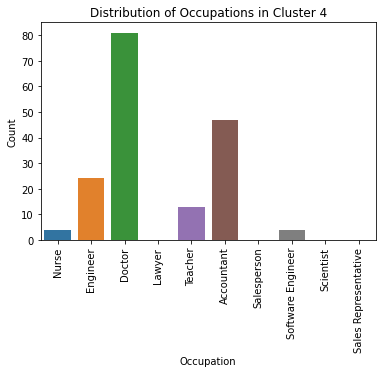

In [101]:
# Cluster 4 occupation distribution
c4_pd = df_km_c4.toPandas()
index_occupation_map = {val: key for key, val in occupation_index_map.items()}

occupation_counts = {}
# Count the occurrences for each occupation index
for i in range(len(index_occupation_map)):
    # Dictionary value will be sum of values in OccupationVector where it is 1 for the occupation (One hot encding)
    occupation_counts[index_occupation_map[i]] = c4_pd['OccupationVector'].apply(lambda x: x[i] == 1.0).sum() 
                     
sns.barplot(x=list(occupation_counts.keys()), y=list(occupation_counts.values()))
plt.title("Distribution of Occupations in Cluster 4")
plt.xlabel("Occupation")
plt.ylabel("Count")
# Rotate them to vertical to make space for value labels
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Nurse'),
  Text(1, 0, 'Engineer'),
  Text(2, 0, 'Doctor'),
  Text(3, 0, 'Lawyer'),
  Text(4, 0, 'Teacher'),
  Text(5, 0, 'Accountant'),
  Text(6, 0, 'Salesperson'),
  Text(7, 0, 'Software Engineer'),
  Text(8, 0, 'Scientist'),
  Text(9, 0, 'Sales Representative')])

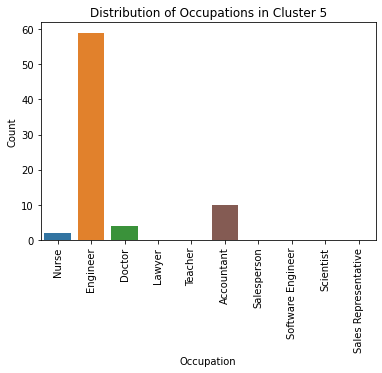

In [102]:
# Cluster 5 occupation distribution
c5_pd = df_km_c5.toPandas()
index_occupation_map = {val: key for key, val in occupation_index_map.items()}

occupation_counts = {}
# Count the occurrences for each occupation index
for i in range(len(index_occupation_map)):
    # Dictionary value will be sum of values in OccupationVector where it is 1 for the occupation (One hot encding)
    occupation_counts[index_occupation_map[i]] = c5_pd['OccupationVector'].apply(lambda x: x[i] == 1.0).sum() 
                     
sns.barplot(x=list(occupation_counts.keys()), y=list(occupation_counts.values()))
plt.title("Distribution of Occupations in Cluster 5")
plt.xlabel("Occupation")
plt.ylabel("Count")
# Rotate them to vertical to make space for value labels
plt.xticks(rotation=90)

/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of BMI Category in Cluster 2')

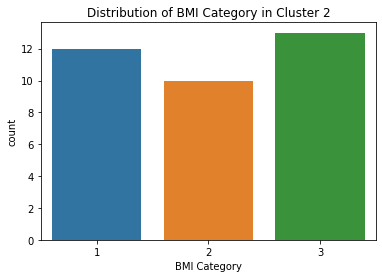

In [103]:
# Only take cluster 2
df_km_c2 = df_km.filter(df_km.prediction == 1)
sns.countplot(df_km_c2.toPandas()['BMI Category'])
plt.title("Distribution of BMI Category in Cluster 2")


/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of BMI Category in Cluster 3')

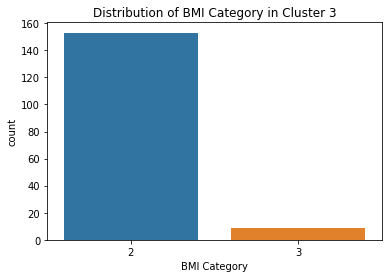

In [104]:
# Only take cluster 2
df_km_c3 = df_km.filter(df_km.prediction == 2)
sns.countplot(df_km_c3.toPandas()['BMI Category'])
plt.title("Distribution of BMI Category in Cluster 3")


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Nurse'),
  Text(1, 0, 'Engineer'),
  Text(2, 0, 'Doctor'),
  Text(3, 0, 'Lawyer'),
  Text(4, 0, 'Teacher'),
  Text(5, 0, 'Accountant'),
  Text(6, 0, 'Salesperson'),
  Text(7, 0, 'Software Engineer'),
  Text(8, 0, 'Scientist'),
  Text(9, 0, 'Sales Representative')])

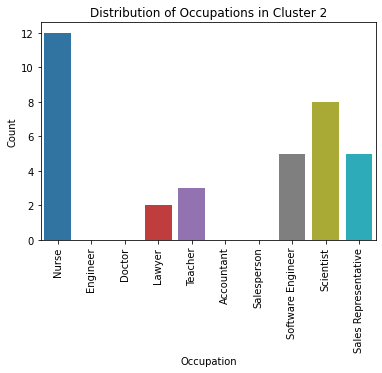

In [105]:
# Cluster 2 occupation distribution
c2_pd = df_km_c2.toPandas()
index_occupation_map = {val: key for key, val in occupation_index_map.items()}

occupation_counts = {}
# Count the occurrences for each occupation index
for i in range(len(index_occupation_map)):
    # Dictionary value will be sum of values in OccupationVector where it is 1 for the occupation (One hot encding)
    occupation_counts[index_occupation_map[i]] = c2_pd['OccupationVector'].apply(lambda x: x[i] == 1.0).sum() 
                     
sns.barplot(x=list(occupation_counts.keys()), y=list(occupation_counts.values()))
plt.title("Distribution of Occupations in Cluster 2")
plt.xlabel("Occupation")
plt.ylabel("Count")
# Rotate them to vertical to make space for value labels
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Nurse'),
  Text(1, 0, 'Engineer'),
  Text(2, 0, 'Doctor'),
  Text(3, 0, 'Lawyer'),
  Text(4, 0, 'Teacher'),
  Text(5, 0, 'Accountant'),
  Text(6, 0, 'Salesperson'),
  Text(7, 0, 'Software Engineer'),
  Text(8, 0, 'Scientist'),
  Text(9, 0, 'Sales Representative')])

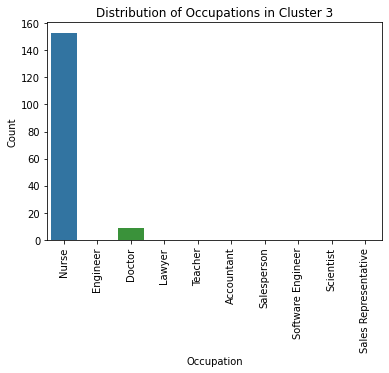

In [106]:
# Cluster 3 occupation distribution
c3_pd = df_km_c3.toPandas()
index_occupation_map = {val: key for key, val in occupation_index_map.items()}

occupation_counts = {}
# Count the occurrences for each occupation index
for i in range(len(index_occupation_map)):
    # Dictionary value will be sum of values in OccupationVector where it is 1 for the occupation (One hot encding)
    occupation_counts[index_occupation_map[i]] = c3_pd['OccupationVector'].apply(lambda x: x[i] == 1.0).sum() 
                     
sns.barplot(x=list(occupation_counts.keys()), y=list(occupation_counts.values()))
plt.title("Distribution of Occupations in Cluster 3")
plt.xlabel("Occupation")
plt.ylabel("Count")
# Rotate them to vertical to make space for value labels
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Nurse'),
  Text(1, 0, 'Engineer'),
  Text(2, 0, 'Doctor'),
  Text(3, 0, 'Lawyer'),
  Text(4, 0, 'Teacher'),
  Text(5, 0, 'Accountant'),
  Text(6, 0, 'Salesperson'),
  Text(7, 0, 'Software Engineer'),
  Text(8, 0, 'Scientist'),
  Text(9, 0, 'Sales Representative')])

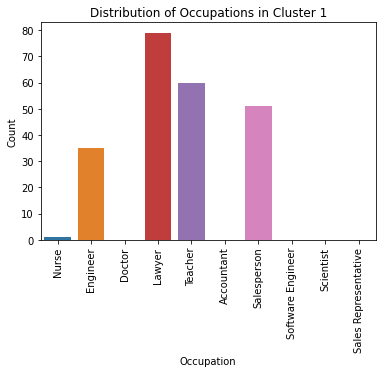

In [107]:
df_km_c1 = df_km.filter(df_km.prediction == 0)

# Cluster 1 occupation distribution
c1_pd = df_km_c1.toPandas()
index_occupation_map = {val: key for key, val in occupation_index_map.items()}

occupation_counts = {}
# Count the occurrences for each occupation index
for i in range(len(index_occupation_map)):
    # Dictionary value will be sum of values in OccupationVector where it is 1 for the occupation (One hot encding)
    occupation_counts[index_occupation_map[i]] = c1_pd['OccupationVector'].apply(lambda x: x[i] == 1.0).sum() 
                     
sns.barplot(x=list(occupation_counts.keys()), y=list(occupation_counts.values()))
plt.title("Distribution of Occupations in Cluster 1")
plt.xlabel("Occupation")
plt.ylabel("Count")
# Rotate them to vertical to make space for value labels
plt.xticks(rotation=90)


## 8.5 Iterations

In [131]:
# Drop log'd columns again
df_rf_2 = df_occ.drop("Daily Steps")
df_rf_2 = df_rf_2.drop("Physical Activity Level")

# String index for Bedtime
indexer_bt = StringIndexer(inputCol="Bedtime", outputCol="BedtimeIndex")
df_rf_2 = indexer_bt.fit(df_rf_2).transform(df_rf_2)

# Apply OneHotEncoder to the indexed column
encoder_bt = OneHotEncoder(inputCol="BedtimeIndex", outputCol="BedtimeVector")
df_rf_2 = encoder_bt.fit(df_rf_2).transform(df_rf_2)

df_rf_2.show()


+----+---+--------------+------------+------------+---------------------+-------------------+-------+--------+--------+---------+----------------+---------------------------+-----------------+------------+---------------+
|Male|Age|Sleep Duration|Stress Level|BMI Category|Quality_of_Sleep_Tier|Have_Sleep_Disorder|Bedtime|PhoneUse|Systolic|Diastolic|OccupationVector|Physical_Activity_Level_Log|  Daily_Steps_Log|BedtimeIndex|  BedtimeVector|
+----+---+--------------+------------+------------+---------------------+-------------------+-------+--------+--------+---------+----------------+---------------------------+-----------------+------------+---------------+
|   1| 27|           6.1|           6|           2|                    1|                  0|   1:00|       1|     126|       83|  (10,[7],[1.0])|         3.7376696182833684|8.556413904569519|         7.0| (41,[7],[1.0])|
|   1| 28|           6.2|           8|           1|                    1|                  0|   0:30|       0|  

In [132]:
# Group by in df_occ which was before it was preprocessed using One hot encoder
bedtime_dist = df_occ.groupBy("Bedtime").agg(count("Bedtime").alias("count"))

# Sort them such that they match the StringIndexer where most frequent occupation gets 0 etc.
sorted_bedtime = bedtime_dist.orderBy(desc("count")).collect()

# Create a dictionary mapping bedtime values to indices
bedtime_index_map = {row["Bedtime"]: index for index, row in enumerate(sorted_bedtime)}
print(bedtime_index_map)

{'0:00': 0, '23:30': 1, '23:00': 2, '1:30': 3, '0:30': 4, '2:00': 5, '22:30': 6, '22:00': 7, '1:00': 8, '1:15': 9, '1:20': 10, '3:00': 11, '0:50': 12, '23:40': 13, '2:30': 14, '0:40': 15, '23:50': 16, '1:40': 17, '2:40': 18, '21:00': 19, '2:20': 20, '23:10': 21, '1:50': 22, '1:45': 23, '0:20': 24, '22:40': 25, '21:30': 26, '3:10': 27, '1:10': 28, '3:30': 29, '22:15': 30, '11:30': 31, '22:20': 32, '23:15': 33, '2:15': 34, '22:50': 35, '2:50': 36, '21:45': 37, '2:45': 38, '4:30': 39, '23:20': 40, '9:30': 41}


### Random Forest (Quality of Sleep Tier)

In [137]:
# Drop bedtime
df_rf_2 = df_rf_2.drop("Bedtime")
df_rf_2 = df_rf_2.drop("BedtimeIndex")
# Get every column other than target label
X_qos_2 = [col for col in df_rf_2.columns if col != "Quality_of_Sleep_Tier"]

# Transform to features
rf_qos_assembler_2 = VectorAssembler(inputCols=X_qos_2, outputCol="features")
df_rf_qos_2 = rf_qos_assembler_2.transform(df_rf_2)

# Split to train and test
qos_train_2, qos_test_2 = df_rf_qos_2.randomSplit([0.7, 0.3], seed=1)

# Build model
rf_qos_2 = RandomForestClassifier(featuresCol="features", labelCol="Quality_of_Sleep_Tier", maxBins=50)
rf_qos_model_2 = rf_qos_2.fit(qos_train_2)

# Predict
rf_qos_pred_2 = rf_qos_model_2.transform(qos_test_2)

rf_qos_pred_2.show()




+----+---+--------------+------------+------------+---------------------+-------------------+--------+--------+---------+----------------+---------------------------+-----------------+---------------+--------------------+--------------------+--------------------+----------+
|Male|Age|Sleep Duration|Stress Level|BMI Category|Quality_of_Sleep_Tier|Have_Sleep_Disorder|PhoneUse|Systolic|Diastolic|OccupationVector|Physical_Activity_Level_Log|  Daily_Steps_Log|  BedtimeVector|            features|       rawPrediction|         probability|prediction|
+----+---+--------------+------------+------------+---------------------+-------------------+--------+--------+---------+----------------+---------------------------+-----------------+---------------+--------------------+--------------------+--------------------+----------+
|   0| 31|           7.0|           4|           1|                    3|                  0|       1|     117|       76|  (10,[0],[1.0])|         3.4965075614664802|8.5171931

### Feature Importance (Quality of Sleep Tier)

In [138]:
expanded_features = []
# Get bedtime values as occupation_index_map is occupation:index 
bedtime_values = list(bedtime_index_map.keys())
# Loop through each feature in X_qos that already extracted the feature names
for feature in X_qos_2:
    # However, if it is OccupationVector it will go through occupation_values and include them in order
    if feature == "OccupationVector":
        # Only n - 1 categories as last occupation Manager is not included in One Hot Encoding but occupation_index_map removed it from previous code
        for i in range(len(occupation_index_map)):
            expanded_features.append(f"{occupation_values[i]}")
    # If statement for BedtimeVector
    elif feature == "BedtimeVector":
        # Only n - 1 categories as last bedtime is not included in One Hot Encoding
        for i in range(len(bedtime_index_map) - 1):
            expanded_features.append(f"{bedtime_values[i]}")
    else:
        expanded_features.append(feature)
# Get the feature importance values
qos_importances_2 = rf_qos_model_2.featureImportances
# Map the feature name to the value
feature_importances_2 = {expanded_features[i]: importance for i, importance in enumerate(qos_importances_2)}
# Sort the importance values in descending order
feature_importances_2 = sorted(feature_importances_2.items(), key=lambda item: item[1], reverse=True)
for feature, importance in feature_importances_2:
    print(f"{feature}: {importance}")


Sleep Duration: 0.18905079460524715
BMI Category: 0.09289191701867983
Daily_Steps_Log: 0.08988627427220813
Stress Level: 0.08631440891674982
Age: 0.0826043612548726
Diastolic: 0.07028909813235792
Physical_Activity_Level_Log: 0.06624685331826936
Systolic: 0.0568020501466889
Engineer: 0.04396092180288974
Male: 0.019378746742139814
Lawyer: 0.016484994095683367
Salesperson: 0.014642906469795908
Doctor: 0.013734556165470172
PhoneUse: 0.012177014126241961
Have_Sleep_Disorder: 0.012005319076889818
Accountant: 0.011804741802757458
Nurse: 0.011665152744521493
0:00: 0.0114129029802273
0:30: 0.010674009058970209
3:00: 0.009422263485776187
23:00: 0.009360393587788236
23:30: 0.0076266023501911015
22:40: 0.0075271530396868735
1:30: 0.007431413551862063
21:00: 0.005693413987532637
Teacher: 0.005007959429441573
22:15: 0.0034744226684211665
1:15: 0.003313603689340329
2:50: 0.003028426685679703
1:20: 0.0030123051919635994
Software Engineer: 0.0029260458578788465
1:40: 0.0028649759724030106
Scientist: 0.

In [139]:
# Get every column other than target label
X_sd_2 = [col for col in df_rf_2.columns if col != "Have_Sleep_Disorder"]

# Transform to features
rf_sd_assembler_2 = VectorAssembler(inputCols=X_sd_2, outputCol="features")
df_rf_sd_2 = rf_sd_assembler_2.transform(df_rf_2)

# Split to train and test
sd_train_2, sd_test_2 = df_rf_sd_2.randomSplit([0.7, 0.3], seed=1)

# Build model
rf_sd_2 = RandomForestClassifier(featuresCol="features", labelCol="Have_Sleep_Disorder", maxBins=50)
rf_sd_model_2 = rf_sd_2.fit(sd_train_2)

rf_sd_pred_2 = rf_sd_model_2.transform(sd_test_2)

rf_sd_pred_2.show()

+----+---+--------------+------------+------------+---------------------+-------------------+--------+--------+---------+----------------+---------------------------+-----------------+---------------+--------------------+--------------------+--------------------+----------+
|Male|Age|Sleep Duration|Stress Level|BMI Category|Quality_of_Sleep_Tier|Have_Sleep_Disorder|PhoneUse|Systolic|Diastolic|OccupationVector|Physical_Activity_Level_Log|  Daily_Steps_Log|  BedtimeVector|            features|       rawPrediction|         probability|prediction|
+----+---+--------------+------------+------------+---------------------+-------------------+--------+--------+---------+----------------+---------------------------+-----------------+---------------+--------------------+--------------------+--------------------+----------+
|   0| 31|           7.0|           4|           1|                    3|                  0|       1|     117|       76|  (10,[0],[1.0])|         3.4965075614664802|8.5171931

In [140]:
expanded_features = []
# Loop through each feature in X_qos that already extracted the feature names
for feature in X_sd_2:
    # However, if it is OccupationVector it will go through occupation_values and include them in order
    if feature == "OccupationVector":
        # Only n - 1 categories as last occupation Manager is not included in One Hot Encoding but occupation_index_map removed it from previous code
        for i in range(len(occupation_index_map)):
            expanded_features.append(f"{occupation_values[i]}")
    # If statement for BedtimeVector
    elif feature == "BedtimeVector":
        # Only n - 1 categories as last bedtime is not included in One Hot Encoding
        for i in range(len(bedtime_index_map) - 1):
            expanded_features.append(f"{bedtime_values[i]}")
    else:
        expanded_features.append(feature)
# Get the feature importance values
sd_importances_2 = rf_sd_model_2.featureImportances
# Map the feature name to the value
feature_importances_2 = {expanded_features[i]: importance for i, importance in enumerate(sd_importances_2)}
# Sort the importance values in descending order
feature_importances_2 = sorted(feature_importances_2.items(), key=lambda item: item[1], reverse=True)
for feature, importance in feature_importances_2:
    print(f"{feature}: {importance}")


BMI Category: 0.2184701671493406
Systolic: 0.20318391654862095
Diastolic: 0.19778078582223674
Physical_Activity_Level_Log: 0.10334629934378595
Daily_Steps_Log: 0.04342155860657525
Salesperson: 0.03551647593034043
Nurse: 0.03283040989477807
Male: 0.020564813226169813
Age: 0.020372913697183952
Sleep Duration: 0.01960799953198689
Quality_of_Sleep_Tier: 0.01893584738059102
Stress Level: 0.017432731839521615
Doctor: 0.01438339554282135
Engineer: 0.007292468711121455
Lawyer: 0.0066057882488274695
23:15: 0.005490716041184779
Accountant: 0.005061125158645874
PhoneUse: 0.0046686246386678735
22:00: 0.0037369701664314594
3:00: 0.0033452597905313914
0:30: 0.0032052533430689647
1:30: 0.002528029470764648
23:00: 0.0024815461024011677
1:10: 0.0021227593983637687
1:15: 0.001649011815610833
Teacher: 0.0014119691450105716
0:00: 0.0011784929729714826
23:10: 0.0006272458128265843
23:40: 0.0006024726270146257
2:20: 0.0005920548263180461
3:30: 0.0005323476693553464
22:30: 0.00043212532960365763
Scientist: 0

### K-means

In [144]:
km_assembler_2 = VectorAssembler(inputCols=df_rf_2.columns, outputCol="features")
df_km_2 = km_assembler_2.transform(df_rf_2)

# List to sum of squared distances within cluster
wcss_2 = []
# List of silhouette scores
silhouette_scores_2 = []

# Try different values of k (2-10)
for k in range(2, 11):
    km = KMeans(featuresCol="features", k=k, seed=1)
    km_model = km.fit(df_km_2)
    # Equivalent to WCSS
    cost = km_model.summary.trainingCost
    wcss_2.append(cost)
    # Finding silhouette score by assinging cluster
    km_pred = km_model.transform(df_km_2)
    # Evaluating it using ClusteringEvaluator
    evaluator = ClusteringEvaluator(featuresCol="features")
    ss = evaluator.evaluate(km_pred)
    silhouette_scores_2.append(ss)


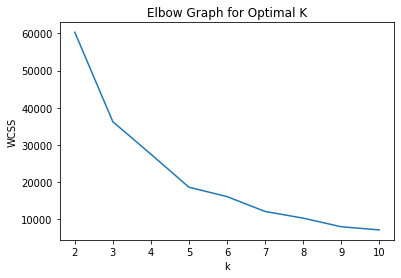

In [145]:
# Plot elbow curve
plt.plot(range(2, 11), wcss_2)
plt.title('Elbow Graph for Optimal K')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.show()

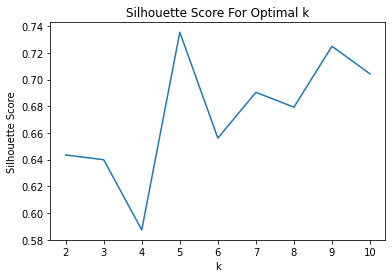

In [146]:
# Plot for Silhouette score
plt.plot(range(2, 11), silhouette_scores_2)
plt.title('Silhouette Score For Optimal k')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.show()

In [147]:
optimal_k = 5

# Build model with the optimal k
km_2 = KMeans(featuresCol="features", k=optimal_k, seed=1)
km_model_2 = km_2.fit(df_km_2)

# Add cluster predictions to the DataFrame
df_km_2 = km_model_2.transform(df_km_2)

# Show clusters
df_km_2.select("features", "prediction").show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|(63,[0,1,2,3,4,5,...|         4|
|(63,[0,1,2,3,4,5,...|         1|
|(63,[0,1,2,3,4,5,...|         1|
|(63,[0,1,2,3,4,5,...|         4|
|(63,[0,1,2,3,4,5,...|         4|
|(63,[0,1,2,3,4,5,...|         4|
|(63,[0,1,2,3,4,5,...|         4|
|(63,[0,1,2,3,4,5,...|         1|
|(63,[0,1,2,3,4,5,...|         1|
|(63,[0,1,2,3,4,5,...|         1|
|(63,[0,1,2,3,4,5,...|         1|
|(63,[0,1,2,3,4,5,...|         1|
|(63,[0,1,2,3,4,5,...|         1|
|(63,[0,1,2,3,4,5,...|         1|
|(63,[0,1,2,3,4,5,...|         1|
|(63,[0,1,2,3,4,5,...|         1|
|(63,[1,2,3,4,5,6,...|         4|
|(63,[0,1,2,3,4,5,...|         1|
|(63,[1,2,3,4,5,6,...|         4|
|(63,[0,1,2,3,4,5,...|         1|
+--------------------+----------+
only showing top 20 rows



In [148]:
# Distribution of cluster values
df_km.groupBy("prediction").agg(count("prediction").alias("count")).show()

expanded_features_km = []
# Loop through each feature in all features for k-means
for feature in df_rf_2.columns:
    # However, if it is OccupationVector it will go through occupation_values and include them in order
    if feature == "OccupationVector":
        # Already removed Manager
        for i in range(len(occupation_index_map)):
            expanded_features_km.append(f"{occupation_values[i]}")
        # If statement for BedtimeVector
    elif feature == "BedtimeVector":
        # Only n - 1 categories as last bedtime is not included in One Hot Encoding
        for i in range(len(bedtime_index_map) - 1):
            expanded_features_km.append(f"{bedtime_values[i]}")
            
    else:
        expanded_features_km.append(feature)
km_centres_2 = km_model_2.clusterCenters() 
print("Cluster centres:") 
i = 1
for centre in km_centres_2: 
    print (f"Cluster {i}")
    i += 1
    # Print out each center value for features in cluster
    cluster_features_2 = {expanded_features_km[i]: cluster_centre for i, cluster_centre in enumerate(centre)}
    for feature in cluster_features_2:
        print (feature, cluster_features_2[feature])
    print ("\n")

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   35|
|         3|  173|
|         4|   75|
|         2|  162|
|         0|  227|
+----------+-----+

Cluster centres:
Cluster 1
Male 0.0
Age 52.77333333333333
Sleep Duration 7.9239999834696455
Stress Level 3.8400000000000003
BMI Category 1.1333333333333333
Quality_of_Sleep_Tier 2.44
Have_Sleep_Disorder 0.2
PhoneUse 0.7200000000000001
Systolic 125.29333333333334
Diastolic 80.45333333333333
Nurse 0.02666666666666667
Engineer 0.7866666666666667
Doctor 0.05333333333333334
Lawyer 0.0
Teacher 0.0
Accountant 0.13333333333333333
Salesperson 0.0
Software Engineer 0.0
Scientist 0.0
Sales Representative 0.0
Physical_Activity_Level_Log 3.5341545406046158
Daily_Steps_Log 8.643409926212051
0:00 0.16
23:30 0.16
23:00 0.21333333333333335
1:30 0.02666666666666667
0:30 0.06666666666666667
2:00 0.0
22:30 0.10666666666666667
22:00 0.02666666666666667
1:00 0.09333333333333334
1:15 0.0
1:20 0.0
3:00 0.0
0:50 0.0
23:40 0.04
2:30 0.0
0:40 

In [149]:
print(bedtime_index_map)

{'0:00': 0, '23:30': 1, '23:00': 2, '1:30': 3, '0:30': 4, '2:00': 5, '22:30': 6, '22:00': 7, '1:00': 8, '1:15': 9, '1:20': 10, '3:00': 11, '0:50': 12, '23:40': 13, '2:30': 14, '0:40': 15, '23:50': 16, '1:40': 17, '2:40': 18, '21:00': 19, '2:20': 20, '23:10': 21, '1:50': 22, '1:45': 23, '0:20': 24, '22:40': 25, '21:30': 26, '3:10': 27, '1:10': 28, '3:30': 29, '22:15': 30, '11:30': 31, '22:20': 32, '23:15': 33, '2:15': 34, '22:50': 35, '2:50': 36, '21:45': 37, '2:45': 38, '4:30': 39, '23:20': 40, '9:30': 41}


/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]),
 [Text(0, 0, '0:00'),
  Text(1, 0, '23:30'),
  Text(2, 0, '23:00'),
  Text(3, 0, '1:30'),
  Text(4, 0, '0:30'),
  Text(5, 0, '2:00'),
  Text(6, 0, '22:30'),
  Text(7, 0, '22:00'),
  Text(8, 0, '1:00'),
  Text(9, 0, '1:15'),
  Text(10, 0, '1:20'),
  Text(11, 0, '3:00'),
  Text(12, 0, '0:50'),
  Text(13, 0, '23:40'),
  Text(14, 0, '2:30'),
  Text(15, 0, '0:40'),
  Text(16, 0, '23:50'),
  Text(17, 0, '1:40'),
  Text(18, 0, '2:40'),
  Text(19, 0, '21:00'),
  Text(20, 0, '2:20'),
  Text(21, 0, '23:10'),
  Text(22, 0, '1:50'),
  Text(23, 0, '1:45'),
  Text(24, 0, '0:20'),
  Text(25, 0, '22:40'),
  Text(26, 0, '21:30'),
  Text(27, 0, '3:10'),
  Text(28, 0, '1:10'),
  Text(29, 0, '3:30'),
  Text(30, 0, '22:15'),
  Text(31, 0, '11:30'),
  Text(32, 0, '22:20'),
  Text(33, 0, '23:15'),
  Text(34, 0, '2:15'),
 

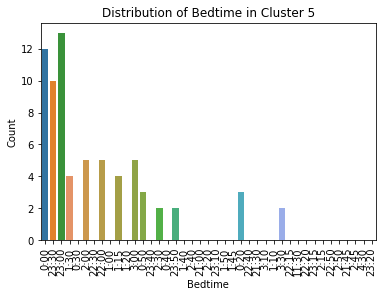

In [151]:
bedtime_index_map = {'0:00': 0, '23:30': 1, '23:00': 2, '1:30': 3, '0:30': 4, '2:00': 5, '22:30': 6, '22:00': 7, '1:00': 8, '1:15': 9, '1:20': 10, '3:00': 11, '0:50': 12, '23:40': 13, '2:30': 14, '0:40': 15, '23:50': 16, '1:40': 17, '2:40': 18, '21:00': 19, '2:20': 20, '23:10': 21, '1:50': 22, '1:45': 23, '0:20': 24, '22:40': 25, '21:30': 26, '3:10': 27, '1:10': 28, '3:30': 29, '22:15': 30, '11:30': 31, '22:20': 32, '23:15': 33, '2:15': 34, '22:50': 35, '2:50': 36, '21:45': 37, '2:45': 38, '4:30': 39, '23:20': 40}

# Only take cluster 5
df_km_c5_2 = df_km_2.filter(df_km_2.prediction == 4)

# Cluster 5 Bedtime distribution
c5_pd_2 = df_km_c5_2.toPandas()
index_bedtime_map = {val: key for key, val in bedtime_index_map.items()}

bedtime_counts = {}
# Count the occurrences for each occupation index
for i in range(len(index_bedtime_map)):
    # Dictionary value will be sum of values in OccupationVector where it is 1 for the occupation (One hot encding)
    bedtime_counts[index_bedtime_map[i]] = c5_pd_2['BedtimeVector'].apply(lambda x: x[i] == 1.0).sum() 
                     
sns.barplot(x=list(bedtime_counts.keys()), y=list(bedtime_counts.values()))
plt.title("Distribution of Bedtime in Cluster 5")
plt.xlabel("Bedtime")
plt.ylabel("Count")
# Rotate them to vertical to make space for value labels
plt.xticks(rotation=90)

/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of BMI Category in Cluster 5')

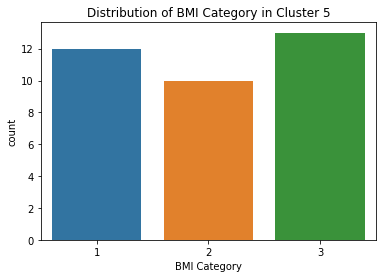

In [152]:
sns.countplot(df_km_c5_2 .toPandas()['BMI Category'])
plt.title("Distribution of BMI Category in Cluster 5")

/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]),
 [Text(0, 0, '0:00'),
  Text(1, 0, '23:30'),
  Text(2, 0, '23:00'),
  Text(3, 0, '1:30'),
  Text(4, 0, '0:30'),
  Text(5, 0, '2:00'),
  Text(6, 0, '22:30'),
  Text(7, 0, '22:00'),
  Text(8, 0, '1:00'),
  Text(9, 0, '1:15'),
  Text(10, 0, '1:20'),
  Text(11, 0, '3:00'),
  Text(12, 0, '0:50'),
  Text(13, 0, '23:40'),
  Text(14, 0, '2:30'),
  Text(15, 0, '0:40'),
  Text(16, 0, '23:50'),
  Text(17, 0, '1:40'),
  Text(18, 0, '2:40'),
  Text(19, 0, '21:00'),
  Text(20, 0, '2:20'),
  Text(21, 0, '23:10'),
  Text(22, 0, '1:50'),
  Text(23, 0, '1:45'),
  Text(24, 0, '0:20'),
  Text(25, 0, '22:40'),
  Text(26, 0, '21:30'),
  Text(27, 0, '3:10'),
  Text(28, 0, '1:10'),
  Text(29, 0, '3:30'),
  Text(30, 0, '22:15'),
  Text(31, 0, '11:30'),
  Text(32, 0, '22:20'),
  Text(33, 0, '23:15'),
  Text(34, 0, '2:15'),
 

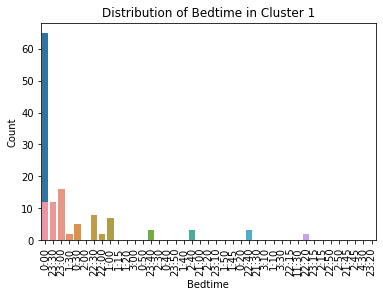

In [153]:
# Only take cluster 1
df_km_c1_2 = df_km_2.filter(df_km_2.prediction == 0)
sns.countplot(df_km_c1_2 .toPandas()['BMI Category'])
plt.title("Distribution of BMI Category in Cluster 1")

# Cluster 1 Bedtime distribution
c1_pd_2 = df_km_c1_2.toPandas()
index_bedtime_map = {val: key for key, val in bedtime_index_map.items()}

bedtime_counts = {}
# Count the occurrences for each occupation index
for i in range(len(index_bedtime_map)):
    # Dictionary value will be sum of values in OccupationVector where it is 1 for the occupation (One hot encding)
    bedtime_counts[index_bedtime_map[i]] = c1_pd_2['BedtimeVector'].apply(lambda x: x[i] == 1.0).sum() 
                     
sns.barplot(x=list(bedtime_counts.keys()), y=list(bedtime_counts.values()))
plt.title("Distribution of Bedtime in Cluster 1")
plt.xlabel("Bedtime")
plt.ylabel("Count")
# Rotate them to vertical to make space for value labels
plt.xticks(rotation=90)

### Evaluation 

In [155]:
# Evaluating Quality of Sleep Tier
evaluator_qos_2 = MulticlassClassificationEvaluator(labelCol="Quality_of_Sleep_Tier", predictionCol="prediction", metricName="accuracy")
# A test error of zero means that the model accuracy is at 100%. 
accuracy = evaluator_qos_2.evaluate(rf_qos_pred_2)
print ("Model 1: Quality of Sleep Tier")
print("Test Error = %g" % (1.0 - accuracy))
print ("Accuracy = %g" % accuracy)

# Select both prediction and actual column
result_qos_2 = rf_qos_pred_2.select("prediction", "Quality_of_Sleep_Tier")
# Have to convert to Double for confusionMatrix
result_qos_2 = result_qos_2.withColumn("Quality_of_Sleep_Tier", col("Quality_of_Sleep_Tier").cast(DoubleType()))
# Cast RDD and map to tuple 
result_qos_2 = MulticlassMetrics(result_qos_2.rdd.map(tuple))
cm_result_qos_2 = result_qos_2.confusionMatrix().toArray()
print (cm_result_qos_2)

# Converting to percentage
total_samples = (cm_result_qos_2).sum(axis=1)
cm_percent_2 = ((cm_result_qos_2 / total_samples) * 100).round(2)
print (cm_percent_2)
# Evaluation metrics for Quality of Sleep Tier
for i in range(1, 4):
    print (f"Precision score for {i}: {result_qos_2.precision(i)}")
    print (f"Recall score for {i}: {result_qos_2.recall(i)}")
    print (f"F1 score for {i}: {result_qos_2.fMeasure(float(i))}")


Model 1: Quality of Sleep Tier
Test Error = 0.273148
Accuracy = 0.726852
[[41. 12. 18.]
 [16. 44. 11.]
 [ 0.  2. 72.]]
[[57.75 16.9  24.32]
 [22.54 61.97 14.86]
 [ 0.    2.82 97.3 ]]
Precision score for 1: 0.7192982456140351
Recall score for 1: 0.5774647887323944
F1 score for 1: 0.6406249999999999
Precision score for 2: 0.7586206896551724
Recall score for 2: 0.6197183098591549
F1 score for 2: 0.6821705426356589
Precision score for 3: 0.7128712871287128
Recall score for 3: 0.972972972972973
F1 score for 3: 0.8228571428571428


In [158]:
# Evaluating Quality of Sleep Tier
evaluator_sd_2 = MulticlassClassificationEvaluator(labelCol="Have_Sleep_Disorder", predictionCol="prediction", metricName="accuracy")
# A test error of zero means that the model accuracy is at 100%. 
accuracy = evaluator_sd_2.evaluate(rf_sd_pred_2)
print ("Model 2: Have Sleep Disorder")
print("Test Error = %g" % (1.0 - accuracy))
print ("Accuracy = %g" % accuracy)

# Select both prediction and actual column
result_sd_2 = rf_sd_pred_2.select("prediction", "Have_Sleep_Disorder")
# Have to convert to Double for confusionMatrix
result_sd_2 = result_sd_2.withColumn("Have_Sleep_Disorder", col("Have_Sleep_Disorder").cast(DoubleType()))
# Cast RDD and map to tuple 
result_sd_2 = MulticlassMetrics(result_sd_2.rdd.map(tuple))
cm_result_sd_2 = result_sd_2.confusionMatrix().toArray()
print (cm_result_sd_2)

# Converting to percentage
total_samples = (cm_result_sd_2).sum(axis=1)
cm_percent_2 = ((cm_result_sd_2 / total_samples) * 100).round(2)
print (cm_percent_2)
# Evaluation metrics for Quality of Sleep Tier
for i in range(0, 2):
    print (f"Precision score for {i}: {result_sd_2.precision(i)}")
    print (f"Recall score for {i}: {result_sd_2.recall(i)}")
    print (f"F1 score for {i}: {result_sd_2.fMeasure(float(i))}")


Model 2: Have Sleep Disorder
Test Error = 0.087963
Accuracy = 0.912037
[[104.   4.]
 [ 15.  93.]]
[[96.3   3.7 ]
 [13.89 86.11]]
Precision score for 0: 0.8739495798319328
Recall score for 0: 0.9629629629629629
F1 score for 0: 0.9162995594713657
Precision score for 1: 0.9587628865979382
Recall score for 1: 0.8611111111111112
F1 score for 1: 0.9073170731707317


### New Train/Test Split

In [159]:
# Split to train and test
qos_train_2, qos_test_2 = df_rf_qos_2.randomSplit([0.8, 0.2], seed=1)

# Build model
rf_qos_2 = RandomForestClassifier(featuresCol="features", labelCol="Quality_of_Sleep_Tier", maxBins=50)
rf_qos_model_2 = rf_qos_2.fit(qos_train_2)

# Predict
rf_qos_pred_2 = rf_qos_model_2.transform(qos_test_2)

# Evaluating Quality of Sleep Tier
evaluator_qos_2 = MulticlassClassificationEvaluator(labelCol="Quality_of_Sleep_Tier", predictionCol="prediction", metricName="accuracy")
# A test error of zero means that the model accuracy is at 100%. 
accuracy = evaluator_qos_2.evaluate(rf_qos_pred_2)
print ("Model 1: Quality of Sleep Tier")
print("Test Error = %g" % (1.0 - accuracy))
print ("Accuracy = %g" % accuracy)

# Select both prediction and actual column
result_qos_2 = rf_qos_pred_2.select("prediction", "Quality_of_Sleep_Tier")
# Have to convert to Double for confusionMatrix
result_qos_2 = result_qos_2.withColumn("Quality_of_Sleep_Tier", col("Quality_of_Sleep_Tier").cast(DoubleType()))
# Cast RDD and map to tuple 
result_qos_2 = MulticlassMetrics(result_qos_2.rdd.map(tuple))
cm_result_qos_2 = result_qos_2.confusionMatrix().toArray()
print (cm_result_qos_2)

# Converting to percentage
total_samples = (cm_result_qos_2).sum(axis=1)
cm_percent_2 = ((cm_result_qos_2 / total_samples) * 100).round(2)
print (cm_percent_2)
# Evaluation metrics for Quality of Sleep Tier
for i in range(1, 4):
    print (f"Precision score for {i}: {result_qos_2.precision(i)}")
    print (f"Recall score for {i}: {result_qos_2.recall(i)}")
    print (f"F1 score for {i}: {result_qos_2.fMeasure(float(i))}")


Model 1: Quality of Sleep Tier
Test Error = 0.246377
Accuracy = 0.753623
[[29.  5. 11.]
 [10. 31.  8.]
 [ 0.  0. 44.]]
[[ 64.44  10.2   25.  ]
 [ 22.22  63.27  18.18]
 [  0.     0.   100.  ]]
Precision score for 1: 0.7435897435897436
Recall score for 1: 0.6444444444444445
F1 score for 1: 0.6904761904761906
Precision score for 2: 0.8611111111111112
Recall score for 2: 0.6326530612244898
F1 score for 2: 0.7294117647058823
Precision score for 3: 0.6984126984126984
Recall score for 3: 1.0
F1 score for 3: 0.822429906542056
